In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import pandas as pd
from datetime import date
# import matplotlib.style as style
# style.use('seaborn-colorblind')
# style.use('Set2')

pd.get_option("display.max_rows",100)
'''/home/alonshp/.conda/envs/tf-env/bin/python'''

sys.path.append(os.path.abspath('../'))
print(sys.path)

from ads.utils.percantage_replicates_utils import *
from ads.utils.plotting import *

['/sise/home/alonshp/AnomalyDetectionScreening/1.evaluate_screen', '/sise/home/alonshp/AnomalyDetectionScreening/1.evaluate_screen', '/home/alonshp/AnomalyDetectionScreening/ads', '/home/alonshp/.conda/envs/pytorch_ads/lib/python310.zip', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/lib-dynload', '', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages', '/sise/home/alonshp/AnomalyDetectionScreening']


## Load data

In [121]:
ds_info_dict={'CDRP':['CDRP-BBBC047-Bray',['Metadata_Sample_Dose','pert_sample_dose']],
              'CDRP-bio':['CDRPBIO-BBBC036-Bray',['Metadata_Sample_Dose','pert_sample_dose']],
              'TAORF':['TA-ORF-BBBC037-Rohban',['Metadata_broad_sample','pert_id',]],
              'LUAD':['LUAD-BBBC041-Caicedo',['x_mutation_status','allele']],
              'LINCS':['LINCS-Pilot1',['Metadata_pert_id_dose','pert_id_dose']]}

################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
# datasets=['TAORF','LUAD','LINCS', 'CDRP-bio']
datasets=['CDRP-bio']
datasets=['LINCS']
dataset= datasets[0]
# DT_kfold={'LUAD':10, 'TAORF':5, 'LINCS':25, 'CDRP-bio':6,'CDRP':40}
exp_name = '0512_t_dd'
by_dose = False
normalize_by_all = True
filter_by_highest_dose = True
# from IPython.display import clear_output
################################################
# CP Profile Type options: 'augmented', 'augmented_after_fs' , 'normalized', 'normalized_variable_selected'
profileType='augmented'
# profileType ='normalized_variable_selected'

z_trim = 8
t_thresholds = [2]


In [122]:
from utils.general import add_exp_suffix

exp_suffix = add_exp_suffix(profileType,by_dose,normalize_by_all)

base_dir= '/sise/assafzar-group/assafzar/genesAndMorph'

data_dir=base_dir+'/preprocessed_data/'+ds_info_dict[datasets[0]][0]+'/'
output_dir = f'{base_dir}/anomaly_output/{datasets[0]}/{profileType}'  
output_dir = f'{base_dir}/anomaly_output/{datasets[0]}/CellPainting/{exp_name}'  
save_base_dir = f'{base_dir}/results/{datasets[0]}'
res_dir = f'{save_base_dir}/CellPainting/{exp_name}/'
exp_save_dir = f'{res_dir}/figs/PR'
# exp_name= 'autoencoder'

methods = defaultdict(dict)
methods['anomaly_err'] = {'name':'anomaly_err','path':os.path.join(output_dir,f'replicate_level_cp_{profileType}_ae_diff.csv')}
methods['raw'] = {'name':'raw','path': os.path.join(output_dir,f'replicate_level_cp_{profileType}_baseline.csv')}

# methods = {
#     # '4to1':{'path':f'/storage/users/g-and-n/tabular_models_results/41/ALL/zscores'},
#     # '2to1':{'path':f'/storage/users/g-and-n/tabular_models_results/21/ALL/zscores'},
#     # 'anomaly':{'name':'anomaly','path':os.path.join(output_dir,f'replicate_level_cp_{profileType}_ae.csv')},
#     'anomaly_err':{'name':'anomaly_err','path':os.path.join(output_dir,f'replicate_level_cp_{profileType}_ae_diff.csv')},
#     # 'anomaly_emb':{'name':'anomaly_emb','path':os.path.join(output_dir,f'replicate_level_cp_{profileType}_ae_embeddings.csv')},
#     'raw':{'name':'raw','path': os.path.join(output_dir,f'replicate_level_cp_{profileType}_baseline.csv')},
#     # 'raw_unchanged':{'name':'raw_unchanged','path': os.path.join(data_dir,'CellPainting',f'replicate_level_cp_{profileType}.csv.gz')}
#     # '5to5':{'path':f'/storage/users/g-and-n/tabular_models_results/55/ALL/zscores'},
# }


p_vals_path = f'{res_dir}/df_null_p_vals{exp_suffix}.csv'
pr_path = f'{res_dir}/pr{exp_suffix}.csv'

os.makedirs(save_base_dir,exist_ok=True)
os.makedirs(exp_save_dir,exist_ok=True)

In [123]:
# from ads.utils.data_utils import set_index_fields
# from dataset_paper_repo.utils.normalize_funcs import standardize_per_catX
from utils.global_variables import DS_INFO_DICT
from utils.data_utils import load_zscores
from utils.metrics import extract_ss_score

new_ss = False
ss_calc = 'median'


methods = load_zscores(methods,base_dir,dataset,profileType,by_dose=by_dose,normalize_by_all =normalize_by_all,z_trim=z_trim,sample='all',set_index=False, filter_by_highest_dose=filter_by_highest_dose)

# (methods,base_dir,dataset, profile_type,normalize_by_all=False,by_dose=False,z_trim=10)
####################### loading zscores #########################

if by_dose:
    ind_col = 'dose_col'
else:
    ind_col = 'cpd_col'

for m in methods.keys():
       
    methods[m]['ind_col'] = DS_INFO_DICT[dataset][methods[m]['modality']][ind_col]
    # features_plus_ind  = [methods[m]['ind_col']]+methods[m]['features']

    zscores_for_ss = methods[m]['zscores'].set_index(methods[m]['ind_col'])[methods[m]['features']]
    if new_ss:
        methods[m]['ss'] = extract_ss_score(zscores_for_ss, th_range=t_thresholds, abs_zscore=False, new_ss = True, value='median',cpd_id_fld = methods[m]['ind_col'])
    else:
        methods[m]['ss'] = extract_ss_score(zscores_for_ss, th_range=t_thresholds, abs_zscore=False, new_ss = new_ss,cpd_id_fld = methods[m]['ind_col']) / len(methods[m]['features'])
    methods[m]['ss'] = methods[m]['ss'].reset_index()

loading zscores for method: anomaly_err


loading zscores for method: raw


### Apply reproducibility labels

In [124]:
# from utils.global_variables import DS_INFO_DICT

dose_col = DS_INFO_DICT[dataset]['CellPainting']['dose_col']
role_col = DS_INFO_DICT[dataset]['CellPainting']['role_col']
cpd_col = DS_INFO_DICT[dataset]['CellPainting']['cpd_col']
mock_col = DS_INFO_DICT[dataset]['CellPainting']['mock_val']
plate_col = DS_INFO_DICT[dataset]['CellPainting']['plate_col']

# methods
reproduce_label = 'Metadata_reproduce'
reproduce_label_with_l1k = 'Metadata_reproduce_w_L1000'

In [125]:
methods[m]['zscores'][role_col].value_counts()

Metadata_ASSAY_WELL_ROLE
treated    17594
mock        1764
Name: count, dtype: int64

In [126]:
# Load RepCorrDF
corr_path = f'{res_dir}/RepCorrDF.xlsx'

# loaded_corr_df = False
if os.path.exists(corr_path):
    # loaded_corr_df = True
    corr_df = pd.read_excel(corr_path, sheet_name=None)
corr_df.keys()

methods_corrs = ['raw','anomaly_err','l1k']
methods_corrs_names = [f'CP-{dataset.lower()}_a_ba',f'anomalyCP-{dataset.lower()}_a_ba',f'l1k-{dataset.lower()}_a_ba']

corrs_dict = {}
for i, mc in enumerate(methods_corrs):
    corrs_dict[mc] = {}
    corrs_dict[mc]['corr_df'] = corr_df[methods_corrs_names[i]]
    # corrs_dict[mc] = corr_df[methods_corrs_names[i]]
    # methods[m]['corr_df'] = 

# mark cpds with RepCorr > 90% as reproducible
for mc in methods_corrs:
    perc90 = corrs_dict[mc]['corr_df']['Rand90Perc'][0]
    # rand_corr = calc_rand_corr(methods[m]['zscores'],pertColName,methods[m]['features'])
    corrs_dict[mc]['reproducible_cpds'] = corrs_dict[mc]['corr_df'][corrs_dict[mc]['corr_df']['RepCor']>perc90]['Unnamed: 0'].to_list()


In [127]:
# apply reproducibility label to all methods with RepCorr > 90%, with l1k
for m in methods.keys():
    # print(f'{m} reproducible cpds: {len(methods[m]["reproducible_cpds"])}')
    methods[m]['zscores'][reproduce_label_with_l1k] = 'DMSO'
    methods[m]['zscores'].loc[methods[m]['zscores'][role_col] != mock_col,reproduce_label_with_l1k] = 'Not reproducible'
    methods[m]['zscores'].loc[methods[m]['zscores'][cpd_col].isin(corrs_dict['raw']['reproducible_cpds']), reproduce_label_with_l1k] = 'Raw'
    methods[m]['zscores'].loc[methods[m]['zscores'][cpd_col].isin(corrs_dict['anomaly_err']['reproducible_cpds']), reproduce_label_with_l1k] = 'Anomaly'
    methods[m]['zscores'].loc[methods[m]['zscores'][cpd_col].isin(corrs_dict['l1k']['reproducible_cpds']), reproduce_label_with_l1k] = 'l1k'
    methods[m]['zscores'].loc[(methods[m]['zscores'][cpd_col].isin(corrs_dict['raw']['reproducible_cpds'])) & (methods[m]['zscores'][cpd_col].isin(corrs_dict['anomaly_err']['reproducible_cpds'])), reproduce_label_with_l1k] = 'Raw & Anomaly'
    methods[m]['zscores'].loc[(methods[m]['zscores'][cpd_col].isin(corrs_dict['raw']['reproducible_cpds'])) & (methods[m]['zscores'][cpd_col].isin(corrs_dict['l1k']['reproducible_cpds'])), reproduce_label_with_l1k] = 'Raw & l1k'
    methods[m]['zscores'].loc[(methods[m]['zscores'][cpd_col].isin(corrs_dict['anomaly_err']['reproducible_cpds'])) & (methods[m]['zscores'][cpd_col].isin(corrs_dict['l1k']['reproducible_cpds'])), reproduce_label_with_l1k] = 'Anomaly & l1k'
    methods[m]['zscores'].loc[(methods[m]['zscores'][cpd_col].isin(corrs_dict['raw']['reproducible_cpds'])) & (methods[m]['zscores'][cpd_col].isin(corrs_dict['anomaly_err']['reproducible_cpds']))
     & (methods[m]['zscores'][cpd_col].isin(corrs_dict['l1k']['reproducible_cpds'])), reproduce_label_with_l1k] = 'Raw & Anomaly & l1k'

# apply reproducibility label to all methods with RepCorr > 90%, without l1k
for m in methods.keys():
    # print(f'{m} reproducible cpds: {len(methods[m]["reproducible_cpds"])}')
    methods[m]['zscores'][reproduce_label] = 'DMSO'
    methods[m]['zscores'].loc[methods[m]['zscores'][role_col] != mock_col,reproduce_label] = 'Not reproducible'
    methods[m]['zscores'].loc[methods[m]['zscores'][cpd_col].isin(corrs_dict['raw']['reproducible_cpds']), reproduce_label] = 'Raw'
    methods[m]['zscores'].loc[methods[m]['zscores'][cpd_col].isin(corrs_dict['anomaly_err']['reproducible_cpds']), reproduce_label] = 'Anomaly'
    methods[m]['zscores'].loc[(methods[m]['zscores'][cpd_col].isin(corrs_dict['raw']['reproducible_cpds'])) & (methods[m]['zscores'][cpd_col].isin(corrs_dict['anomaly_err']['reproducible_cpds'])), reproduce_label] = 'Raw & Anomaly'

/tmp/ipykernel_10476/2329252847.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  methods[m]['zscores'][reproduce_label_with_l1k] = 'DMSO'
/tmp/ipykernel_10476/2329252847.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  methods[m]['zscores'][reproduce_label_with_l1k] = 'DMSO'
/tmp/ipykernel_10476/2329252847.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

### Assert data health

In [128]:
methods[m]['zscores'][reproduce_label].value_counts()
methods[m]['zscores'].shape

(19358, 451)

In [129]:
# test that all methods have the same number of features
assert len(set([methods[m]['zscores'].shape[1] for m in methods.keys()]))==1

meta_features = [col for col in methods[m]['zscores'].columns if 'Metadata' in col]
# meta_features
features = methods[m]['features']

In [130]:
for m in methods.keys():
    print(f' {m} shape:')
    print(methods[m]['zscores'].shape)

 anomaly_err shape:
(19358, 451)
 raw shape:
(19358, 451)


In [131]:
methods[m]['zscores'][methods[m]['features']].isna().sum()>1

# get all colunms that contain nan
nan_cols = methods[m]['zscores'][features].columns[methods[m]['zscores'][features].isna().any()].tolist()

# get all rows that contain nan
nan_rows = methods[m]['zscores'][features][methods[m]['zscores'][features].isna().any(axis=1)].index.tolist()
methods[m]['zscores'].loc[nan_rows].isna().sum().sum()

1895

In [132]:
### remove all rows that contain nan
if len(nan_cols)>0:
    methods[m]['zscores'].loc[nan_rows,nan_cols]

# methods[m]['zscores'].loc[:,['Cells_Correlation_Costes_Mito_DNA', 'Cells_Correlation_Costes_RNA_DNA']]
methods[m]['zscores'].loc[nan_rows]['Metadata_Plate'].value_counts()
methods[m]['zscores'].drop(nan_rows,inplace=True)
# methods[m]['zscores']['Metadata_Plate'].value_counts()
# nan_cols

In [133]:
methods[m]['zscores']['Metadata_moa'].value_counts()

Metadata_moa
Adrenergic receptor antagonist                                                                                                                                   257
Cyclooxygenase inhibitor                                                                                                                                         210
dopamine receptor antagonist                                                                                                                                     186
Dopamine receptor antagonist                                                                                                                                     173
glucocorticoid receptor agonist                                                                                                                                  172
                                                                                                                                                                ..

In [134]:
# stadardize MoA labels (lower case)
for m in methods.keys():
    methods[m]['zscores']['Metadata_moa'] = methods[m]['zscores']['Metadata_moa'].map(lambda x: str(x).lower()) 
    methods[m]['zscores']['Metadata_moa'] = methods[m]['zscores']['Metadata_moa'].replace('nan',np.nan)


In [135]:
methods[m]['zscores']['Metadata_moa'].value_counts()

Metadata_moa
adrenergic receptor antagonist                                          396
dopamine receptor antagonist                                            359
cyclooxygenase inhibitor                                                286
serotonin receptor antagonist                                           282
acetylcholine receptor antagonist                                       266
                                                                       ... 
oxidative stress inducer                                                  7
casein kinase inhibitor|tgf beta receptor inhibitor                       7
dna dependent protein kinase inhibitor|mtor inhibitor|pi3k inhibitor      7
jak inhibitor|lipocortin synthesis stimulant|stat inhibitor               7
gaba uptake inhibitor|gat inhibitor                                       6
Name: count, Length: 595, dtype: int64

## Investigate Plate Effects

### Investigate replicate level compunds

In [136]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
import umap


# pcas={}
# tsnes={}
# umaps={}

for m in methods.keys():
    print(m)
    # if model!='pure':
    if m == 'raw_unchnaged':
        methods[m]['features'] = methods['raw']['features']
        
    x = methods[m]['zscores'][methods[m]['features']]
    # x= x.fillna(0)

    # sc = StandardScaler()
    # X_scaled = sc.fit_transform(x.values)
    X_scaled = x.copy()
    # print('Running PCA...')

    print('Running UMAP...')

    reducer = umap.UMAP(n_neighbors=15, n_components=2)
    # methods[m]['zscores_umap'] = {}
    X_reduced = reducer.fit_transform(X_scaled)
    print(X_reduced.shape)
    print(methods[m]['zscores'].shape)
    methods[m]['zscores'] = pd.concat([methods[m]['zscores'],pd.DataFrame(X_reduced,columns=['UMAP1','UMAP2'])],axis=1)
    # umap_zscores= pd.concat([methods[m]['zscores'],pd.DataFrame(X_reduced,columns=['UMAP1','UMAP2'])],axis=1)

    pad = 0.25
    methods[m]['umap_zscores_lims'] = [methods[m]['zscores']['UMAP1'].min()-pad,methods[m]['zscores']['UMAP1'].max()+pad,methods[m]['zscores']['UMAP2'].min()-pad,methods[m]['zscores']['UMAP2'].max()+pad]
    # print(umap_zscores.shape)
    # features = 
    # methods[m]['zscores_umap'] = pd.DataFrame(X_reduced,columns=['UMAP1','UMAP2'],index=methods[m]['zscores'][methods[m]['ind_col']]).reset_index()


anomaly_err
Running UMAP...


(19358, 2)
(19358, 451)
raw
Running UMAP...
(19007, 2)
(19007, 451)


anomaly_err with (19358, 453)


/tmp/ipykernel_10476/4043214247.py:22: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue=role_col,alpha=1, s=1, palette=['silver','red'], ax=ax[1],legend=True,hue_order=['treated'])
/tmp/ipykernel_10476/4043214247.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data =DMSO_ONLY, x=f'{method}1',y=f'{method}2', hue='is_reproducible', s=2,alpha=0.4, palette=['BLUE'], ax=ax[3],legend=True,hue_order=['DMSO'])


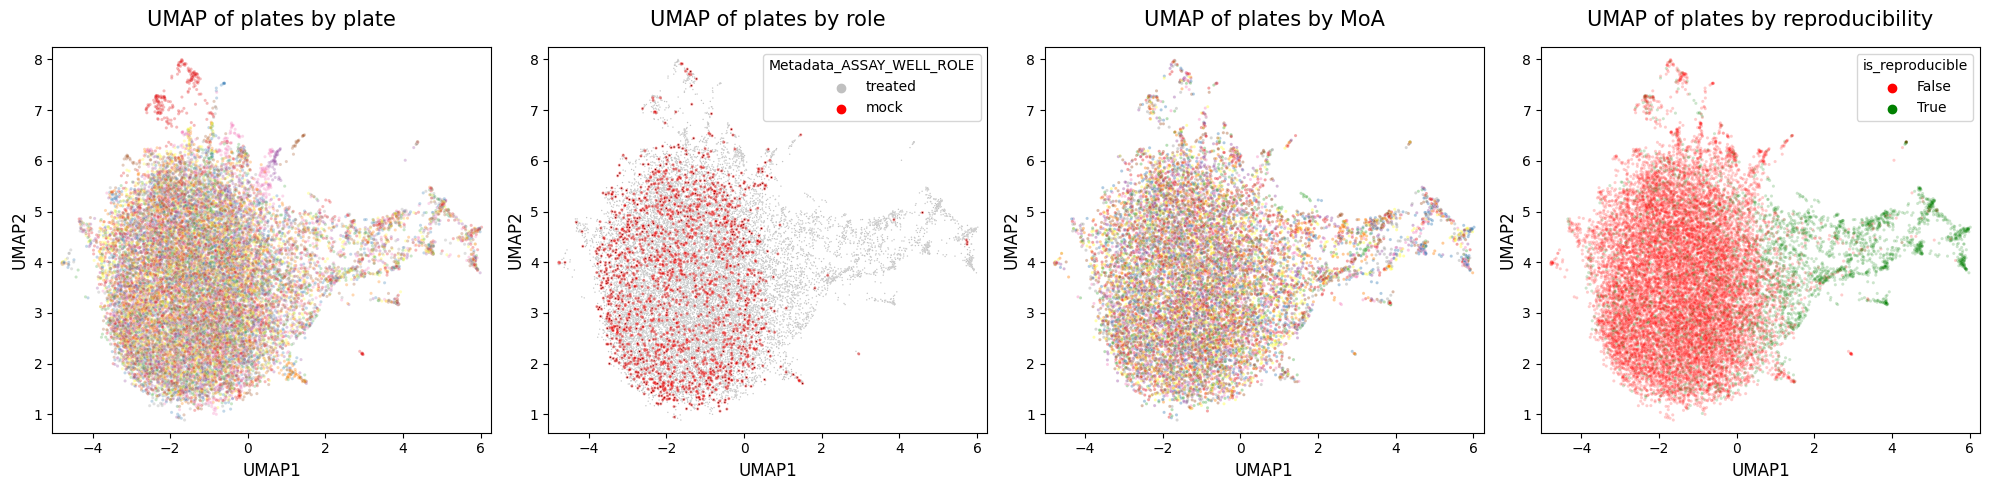

raw with (19358, 453)


/tmp/ipykernel_10476/4043214247.py:22: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue=role_col,alpha=1, s=1, palette=['silver','red'], ax=ax[1],legend=True,hue_order=['treated'])
/tmp/ipykernel_10476/4043214247.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data =DMSO_ONLY, x=f'{method}1',y=f'{method}2', hue='is_reproducible', s=2,alpha=0.4, palette=['BLUE'], ax=ax[3],legend=True,hue_order=['DMSO'])


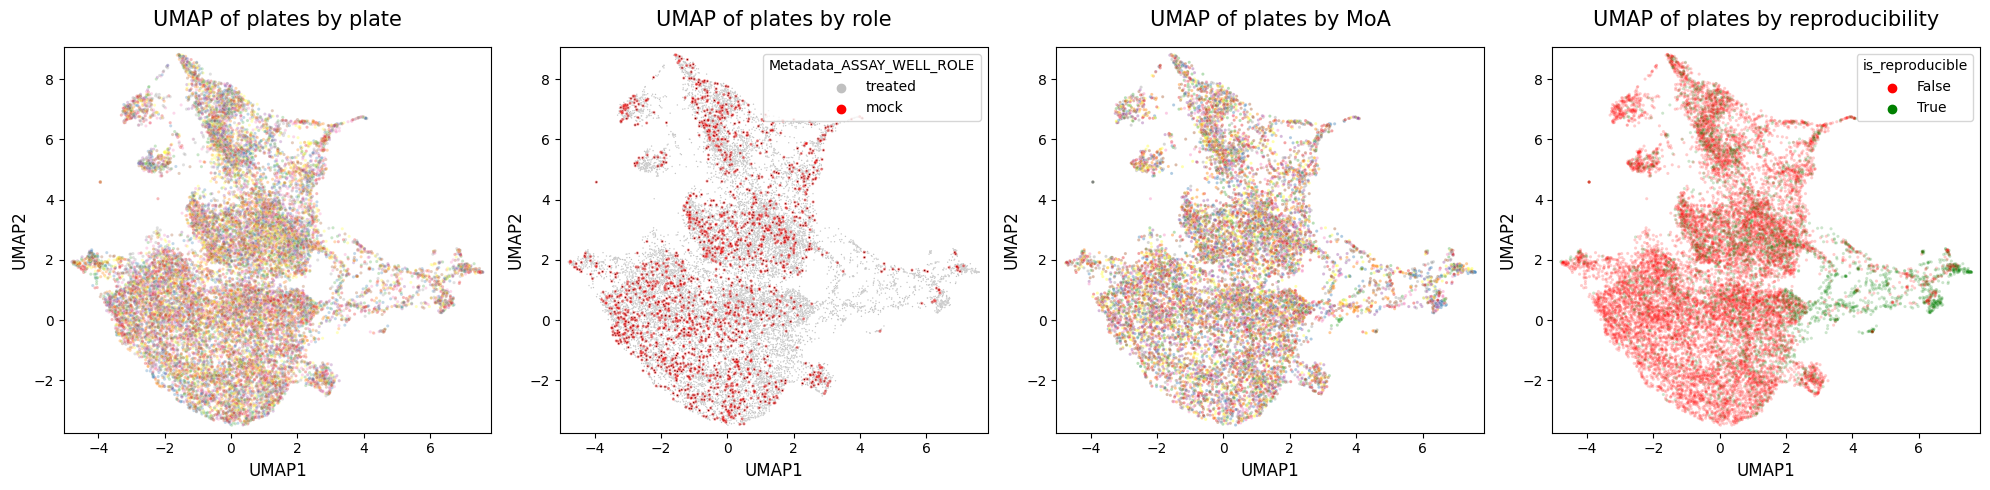

In [137]:
import matplotlib.pyplot as plt 
import seaborn as sns 


lim =10
method = 'UMAP'
for m in methods.keys():
    # if model!='pure':
        c = methods[m]['zscores'].copy()
        # b = pd.DataFrame(umaps[m],columns=[f'{method}1',f'{method}2']).copy()
        # b[b>lim]=lim
        # b[b<-lim]=-lim
        # c = pd.concat([a,b],axis=1)
        # c[c['PCA1']>50]
        print(f'{m} with {c.shape}')
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue=plate_col,alpha=0.3, s=5, palette='Set1', ax=ax[0],legend=False)
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1],legend=False)
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Metadata_ASSAY_WELL_ROLE',alpha=0.2, palette='Set2', ax=ax[2], legend=False)
        
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1])
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue=role_col,alpha=1, s=1, palette=['silver','red'], ax=ax[1],legend=True,hue_order=['treated'])
        DMSO = c[c[role_col]==mock_col]
        sns.scatterplot(data =DMSO, x=f'{method}1',y=f'{method}2', hue=role_col, s=5,alpha=0.4, palette=['red'], ax=ax[1],legend=True)
        # sns.scatterplot(data =c, x=f'{method}1'

        c = c[c[role_col]!='mock']
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_moa', s=5,alpha=0.4, palette='Set1', ax=ax[2],legend=False)
        # g = sns.scatterplot(data=c, x=f'{method}1', y=f'{method}2', hue="mock", s=10, palette=["red", "silver"],ax=ax[2])
        # sns.scatterplot(data=c, x=f'{method}1', y=f'{method}2', s=100, hue="Metadata_moa", palette="nipy_spectral",ax=ax[2],legend=False)
        # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        # ,y=f'{method}2', hue='Metadata_broad_sample',alpha=0.2, palette='Set1', ax=ax[3],legend=False)
        c.loc[c[reproduce_label]!='Not reproducible','is_reproducible'] = 'True'
        c.loc[c[reproduce_label]=='DMSO','is_reproducible'] = 'DMSO'
        c.loc[c[reproduce_label]=='Not reproducible','is_reproducible'] = 'False'

        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='is_reproducible',alpha=0.2, s=5, palette=['red','green'], ax=ax[3],legend=True,hue_order=['False','True'])
        DMSO_ONLY = c[c[reproduce_label]=='DMSO']
        sns.scatterplot(data =DMSO_ONLY, x=f'{method}1',y=f'{method}2', hue='is_reproducible', s=2,alpha=0.4, palette=['BLUE'], ax=ax[3],legend=True,hue_order=['DMSO'])

        ax[0].set_title(f'{method} of plates by plate', fontsize=15, pad=15)
        # ax[1].set_title("PCA of plates by well", fontsize=15, pad=15)
        ax[1].set_title(f'{method} of plates by role', fontsize=15, pad=15)
        ax[2].set_title(f'{method} of plates by MoA', fontsize=15, pad=15)
        ax[3].set_title(f'{method} of plates by reproducibility', fontsize=15, pad=15)

        for i in range(4):
            ax[i].set_xlim(methods[m]['umap_zscores_lims'][0],methods[m]['umap_zscores_lims'][1])
            ax[i].set_ylim(methods[m]['umap_zscores_lims'][2],methods[m]['umap_zscores_lims'][3])
            ax[i].set_xlabel(f'{method}1', fontsize=12)
            ax[i].set_ylabel(f'{method}2', fontsize=12)


        # plt.savefig(os.path.join(args.exp_dir,'PCA of '+ exp_name + '.png'), dpi=80)
        plt.tight_layout()
        plt.show()

### Investigate treatment level compounds

In [138]:
# group all replicates into treatment level representations
for m in methods.keys():
    print(f' {m} shape:')
    print(methods[m]['zscores'].shape)

    methods[m]['treatment_level'] = methods[m]['zscores'].groupby([cpd_col])[features].mean().reset_index()
    print(f' {m} treatment level shape:')
    methods[m]['treatment_level'] = pd.merge(methods[m]['treatment_level'],methods[m]['zscores'][meta_features].drop_duplicates(),on=cpd_col,how='left')
    methods[m]['treatment_level'] = methods[m]['treatment_level'].drop_duplicates(subset=[cpd_col])
    print(methods[m]['treatment_level'].shape)

    # add signature strength to df
    methods[m]['treatment_level'] = pd.merge(methods[m]['treatment_level'],methods[m]['ss'],on=methods[m]['ind_col'])
    print(methods[m]['treatment_level'].shape)
# methods[m]['treatment_level'].head()
# treatment_level = wells.groupby(cpd_col).mean().reset_index()

 anomaly_err shape:
(19358, 453)
 anomaly_err treatment level shape:
(2240, 451)
(2240, 454)
 raw shape:
(19358, 453)
 raw treatment level shape:
(2240, 451)
(2240, 454)


In [139]:
def filter_by_moa(df, moa_col='Metadata_moa',nSamplesMOA=4, cpd_col='Metadata_broad_sample'):
    
    nSamplesforEachMOAclass=df.groupby([cpd_col]).sample(1).groupby([moa_col]).size().\
    reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)


    nSamplesforEachMOAclass2=df.groupby([moa_col]).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)

    listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>nSamplesMOA][moa_col].tolist()
    print('If we filter to MoAs which have more than',nSamplesMOA+1,' compounds in their category, ',\
        len(listOfSelectedMoAs),' out of ',nSamplesforEachMOAclass.shape[0] ,' MoAs remain.')

    multi_label_MoAs=[l for l in listOfSelectedMoAs if '|' in l]
    print('There are ',len(listOfSelectedMoAs),'MoA categories, which out of them ',len(multi_label_MoAs),\
        ' have multi labels and is removed')

    listOfSelectedMoAs=[ele for ele in listOfSelectedMoAs if ele not in multi_label_MoAs]

    return df[df[moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True)

In [140]:
for m in methods.keys():
    methods[m]['treatment_level'] = filter_by_moa(methods[m]['treatment_level'], moa_col='Metadata_moa',nSamplesMOA=4, cpd_col='Metadata_broad_sample')

If we filter to MoAs which have more than 5  compounds in their category,  55  out of  595  MoAs remain.
There are  55 MoA categories, which out of them  0  have multi labels and is removed
If we filter to MoAs which have more than 5  compounds in their category,  55  out of  595  MoAs remain.
There are  55 MoA categories, which out of them  0  have multi labels and is removed


In [141]:
methods[m]['treatment_level']['Metadata_moa'].value_counts()

Metadata_moa
adrenergic receptor antagonist             50
dopamine receptor antagonist               47
cyclooxygenase inhibitor                   38
serotonin receptor antagonist              37
acetylcholine receptor antagonist          35
adrenergic receptor agonist                34
histamine receptor antagonist              29
serotonin receptor agonist                 29
glutamate receptor antagonist              27
glucocorticoid receptor agonist            24
dopamine receptor agonist                  22
phosphodiesterase inhibitor                22
sodium channel blocker                     20
calcium channel blocker                    19
bacterial cell wall synthesis inhibitor    16
adenosine receptor antagonist              14
egfr inhibitor                             14
estrogen receptor agonist                  13
acetylcholine receptor agonist             12
monoamine oxidase inhibitor                12
cannabinoid receptor agonist               11
ppar receptor agonist

In [142]:

for m in methods.keys():
    print(m)
    # if model!='pure':
    # if m == 'raw_unchnaged':
        # methods[m]['features'] = methods['raw']['features']
    x = methods[m]['treatment_level'][features]
    
    X_scaled = x.copy()


    print('Running UMAP...')

    reducer = umap.UMAP(n_neighbors=15, n_components=2)
    # methods[m]['umaps'] = reducer.fit_transform(X_scaled)
    X_reduced = reducer.fit_transform(X_scaled)
    # features = 
    print(X_reduced.shape)
    print(methods[m]['treatment_level'].shape)
    methods[m]['treatment_level'] = pd.concat([methods[m]['treatment_level'],pd.DataFrame(X_reduced,columns=['UMAP1','UMAP2'])],axis=1)
    pad = 0.25
    methods[m]['umap_treatment_levels_lims'] = [methods[m]['treatment_level']['UMAP1'].min()-pad,methods[m]['treatment_level']['UMAP1'].max()+pad,methods[m]['treatment_level']['UMAP2'].min()-pad,methods[m]['treatment_level']['UMAP2'].max()+pad]
    print(methods[m]['treatment_level'].shape)

anomaly_err
Running UMAP...
(778, 2)
(778, 454)
(778, 456)
raw
Running UMAP...


(778, 2)
(778, 454)
(778, 456)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


anomaly_err with (778, 456)


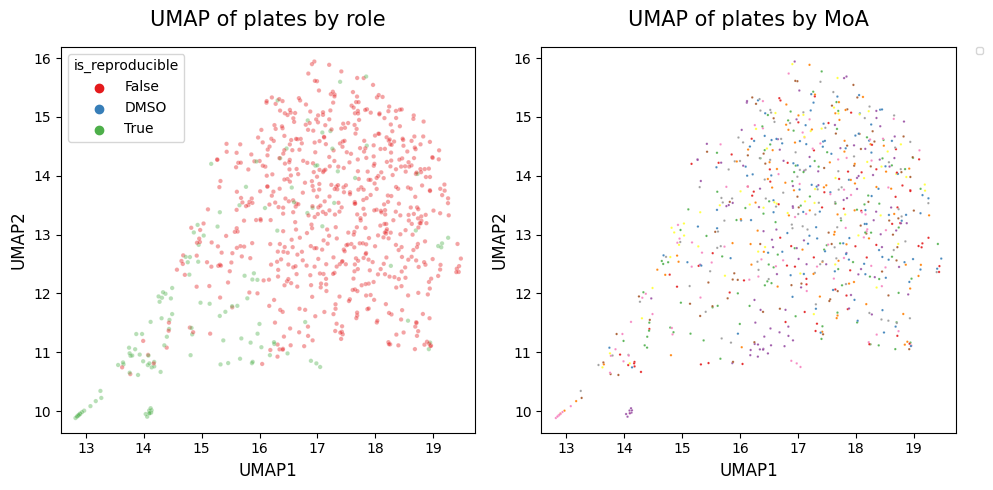

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


raw with (778, 456)


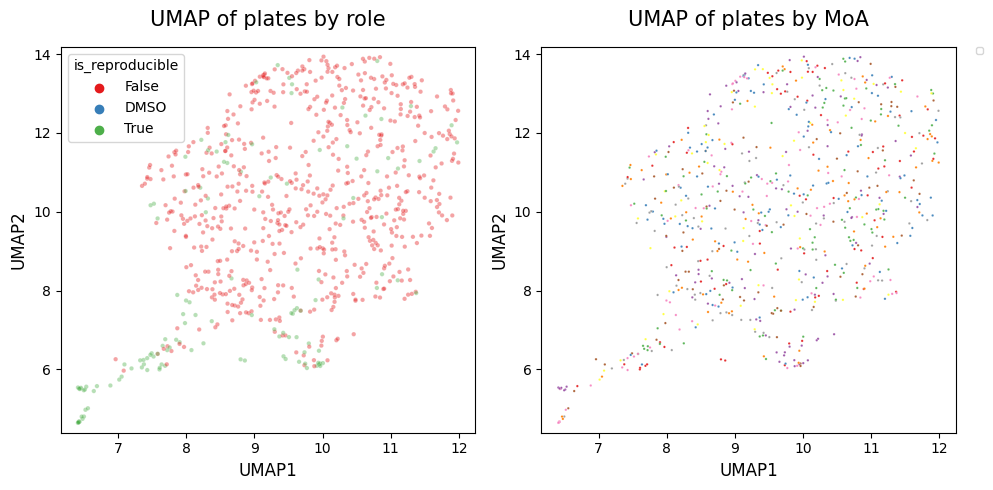

In [143]:
import matplotlib.pyplot as plt 
import seaborn as sns 


for m in methods.keys():
    # if model!='pure':
        c = methods[m]['treatment_level'].copy()
        # b = pd.DataFrame(methods[m]['umaps'],columns=[f'{method}1',f'{method}2']).copy()
        # b[b>lim]=lim
        # b[b<-lim]=-lim
        # c = pd.concat([a,b],axis=1)

        # filter out MoAs with less than 5 compounds
        
        # c[c['PCA1']>50]
        print(f'{m} with {c.shape}')
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue=DS_INFO_DICT[dataset]['CellPainting']['plate_col'],alpha=0.3, palette='Set1', ax=ax[0],legend=False,)
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1],legend=False)
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Metadata_ASSAY_WELL_ROLE',alpha=0.2, palette='Set2', ax=ax[2], legend=False)
        c.loc[c[reproduce_label]!='Not reproducible','is_reproducible'] = 'True'
        c.loc[c[reproduce_label]=='DMSO','is_reproducible'] = 'DMSO'
        c.loc[c[reproduce_label]=='Not reproducible','is_reproducible'] = 'False'

        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='is_reproducible',alpha=0.4, s=10, palette='Set1', ax=ax[0],legend=True,hue_order=['False','DMSO','True'])
        dmso = c[c[reproduce_label]=='DMSO']
        sns.scatterplot(data =dmso, x=f'{method}1',y=f'{method}2', hue=reproduce_label,alpha=0.9, s=50, color='blue', ax=ax[1],legend=True)
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1])
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue=DS_INFO_DICT[dataset]['CellPainting']['role_col'],alpha=0.4, palette='Set1', ax=ax[0],legend=True,hue_order=['treated','mock'])
        # sns.scatterplot(data =c, x=f'{method}1'
        # c = c[c['Metadata_moa'].isin(c['Metadata_moa'].value_counts()[c['Metadata_moa'].value_counts()>9].index)]
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.9, palette='Set1', ax=ax[1],legend=False,s=3)
        # g = sns.scatterplot(data=c, x=f'{method}1', y=f'{method}2', hue="mock", s=10, palette=["red", "silver"],ax=ax[2])
        # sns.scatterplot(data=c, x=f'{method}1', y=f'{method}2', s=100, hue="Metadata_moa", palette="nipy_spectral",ax=ax[2],legend=False)
        ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize = 6)
        # ,y=f'{method}2', hue='Metadata_broad_sample',alpha=0.2, palette='Set1', ax=ax[3],legend=False)

        
        # ax[1].set_title("PCA of plates by well", fontsize=15, pad=15)
        for a in ax:
            a.set_xlabel(f'{method}1', fontsize=12)
            a.set_ylabel(f'{method}2', fontsize=12)
            a.set_xlim(methods[m]['umap_treatment_levels_lims'][0],methods[m]['umap_treatment_levels_lims'][1])
            a.set_ylim(methods[m]['umap_treatment_levels_lims'][2],methods[m]['umap_treatment_levels_lims'][3])
            
        ax[0].set_title(f'{method} of plates by role', fontsize=15, pad=15)
        ax[1].set_title(f'{method} of plates by MoA', fontsize=15, pad=15)
        # ax[2].set_title("PCA of plates by sample", fontsize=15, pad=15)
        # ax[1].set_title("PCA of IRIS dataset", fontsize=15, pad=15)

        # ax[0].set_xlabel(f'{method}1', fontsize=12)
        # ax[0].set_ylabel(f'{method}2', fontsize=12)

        # ax[1].set_xlabel(f'{method}1', fontsize=12)
        # ax[1].set_ylabel(f'{method}2', fontsize=12)
        
        # ax[2].set_xlabel(f'{method}1', fontsize=12)
        # ax[2].set_ylabel(f'{method}2', fontsize=12)

        # plt.savefig(os.path.join(args.exp_dir,'PCA of '+ exp_name + '.png'), dpi=80)
        plt.tight_layout()
        plt.show()

In [144]:
methods[m]['treatment_level'][reproduce_label_with_l1k].value_counts()

Metadata_reproduce_w_L1000
Not reproducible       538
l1k                    104
Raw & Anomaly & l1k     36
Raw & Anomaly           35
Anomaly                 32
Anomaly & l1k           18
Raw                     14
Raw & l1k                1
Name: count, dtype: int64

anomaly_err with (778, 457), n_Moa = 55


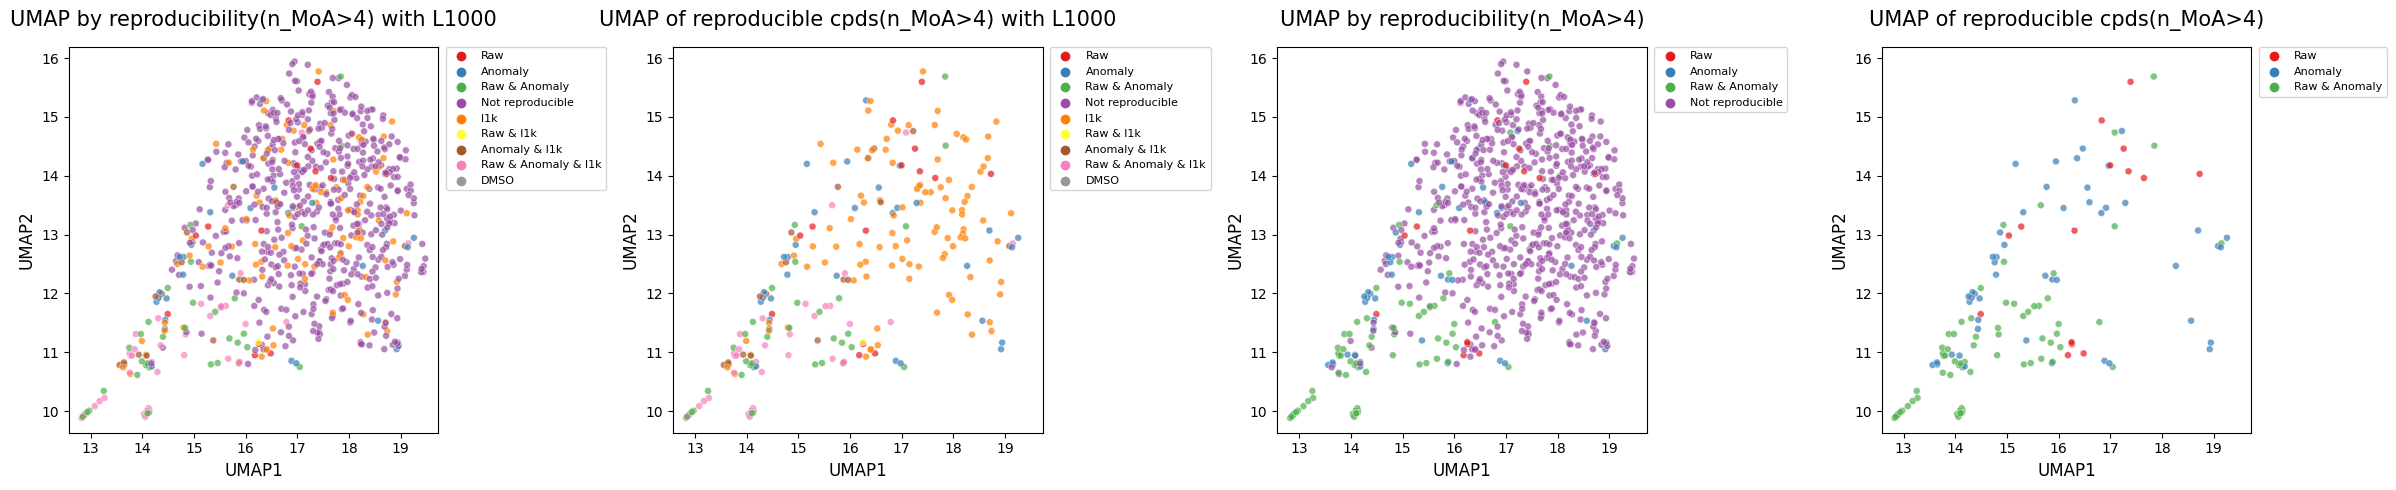

raw with (778, 457), n_Moa = 55


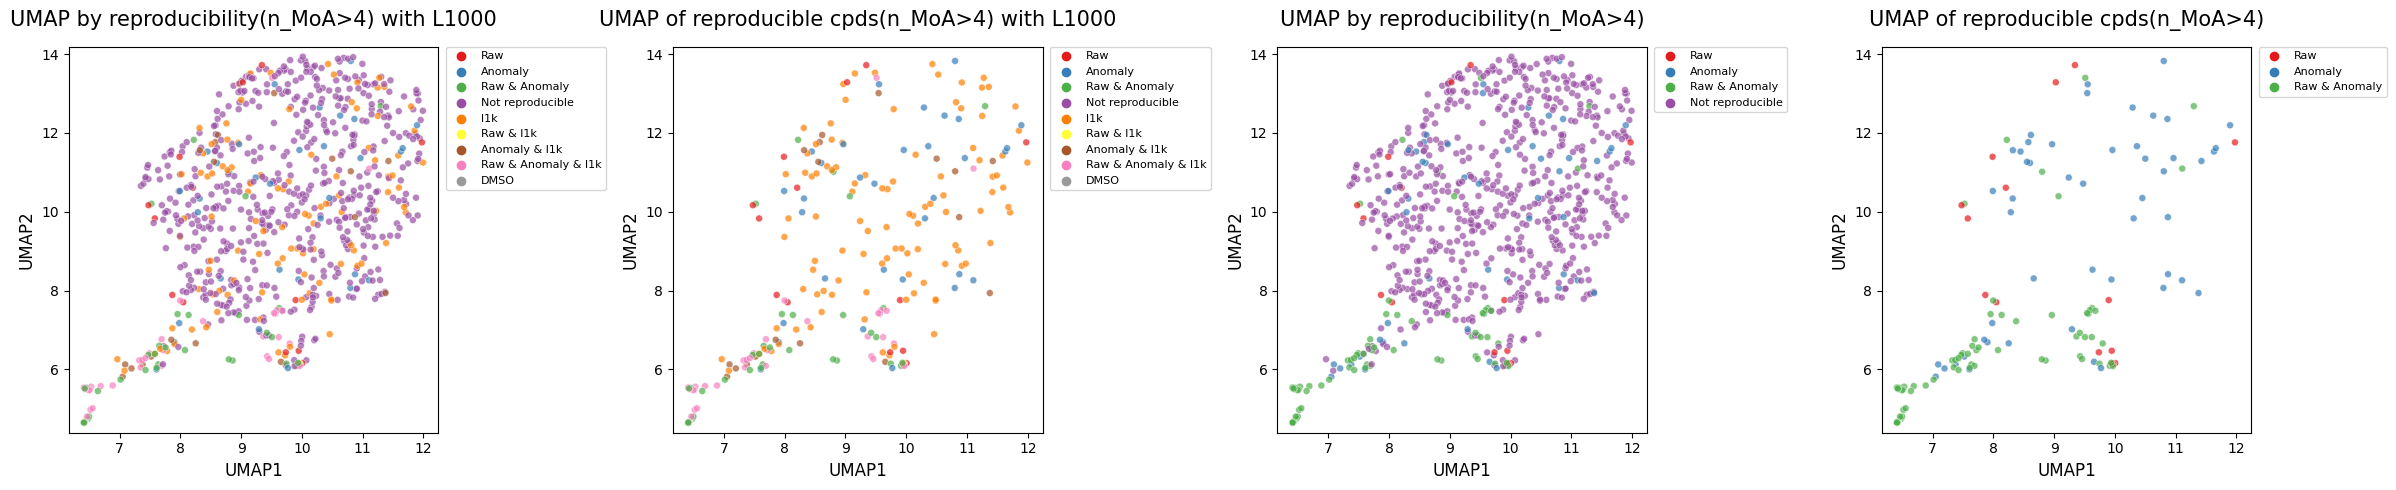

In [145]:
##### inspecting the treatment level profiles by reproducibility #####

methods[m]['UMAP_lims'] = {'UMAP1':[-10,10],'UMAP2':[-10,10]}
for m in methods.keys():
    # if model!='pure':

        # treatment level profiles 
        tlp = methods[m]['treatment_level'].copy()
        
        # filter out MoAs with less than 5 compounds
        # tlp = tlp[tlp['Metadata_moa'].isin(tlp['Metadata_moa'].value_counts()[tlp['Metadata_moa'].value_counts()>4].index)]

        print(f'{m} with {c.shape}, n_Moa = {len(tlp["Metadata_moa"].unique())}')
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 5))

        
        ######### without l1k #########
        ## all cpds ##
        hue_order = ['Raw', 'Anomaly', 'Raw & Anomaly','Not reproducible','l1k', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k','DMSO']
        sns.scatterplot(data=tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,hue_order=hue_order,s=25)
        
        ## only reproducible cpds ##
        tlp_only_reproduce = tlp[tlp[reproduce_label_with_l1k]!='Not reproducible']
        sns.scatterplot(data =tlp_only_reproduce, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[1],legend=True,hue_order=hue_order,s=25)
        # hue_order = ['l1k', 'Raw', 'Anomaly', 'Raw & Anomaly', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k','Not reproducible']

        # c.loc[c[reproduce_label]!='Not reproducible','is_reproducible'] = 'True'
        # c.loc[c[reproduce_label]=='DMSO','is_reproducible'] = 'DMSO'
        # c.loc[c[reproduce_label]=='Not reproducible','is_reproducible'] = 'False'

        
        ######### without l1k #########

        ## all cpds ##
        hue_order = ['Raw', 'Anomaly', 'Raw & Anomaly','Not reproducible']
        # hue_order = ['Raw', 'Anomaly', 'Raw & Anomaly','Not reproducible','l1k', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k']
        sns.scatterplot(data =tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label,alpha=0.7, palette='Set1', ax=ax[2],legend=True,hue_order=hue_order,s=25)


        ## only reproducible cpds ##
        tlp_only_reproduce = tlp[tlp[reproduce_label]!='Not reproducible']
        # hue_order = ['l1k', 'Raw', 'Anomaly', 'Raw & Anomaly', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k']
        hue_order = ['Raw', 'Anomaly', 'Raw & Anomaly']

        sns.scatterplot(data =tlp_only_reproduce, x=f'{method}1',y=f'{method}2', hue=reproduce_label,alpha=0.7, palette='Set1', ax=ax[3],legend=True,hue_order=hue_order,s=25)
        # g = sns.scatterplot(data=c, x=f'{method}1', y=f'{method}2', hue="mock", s=10, palette=["red", "silver"],ax=ax[2])
        # sns.scatterplot(data=c, x=f'{method}1', y=f'{method}2', s=100, hue="Metadata_moa", palette="nipy_spectral",ax=ax[2],legend=False)

        ax[0].set_title(f'{method} by reproducibility(n_MoA>4) with L1000', fontsize=15, pad=15)
        # ax[1].set_title("PCA of plates by well", fontsize=15, pad=15)
        ax[1].set_title(f'{method} of reproducible cpds(n_MoA>4) with L1000', fontsize=15, pad=15)
        ax[2].set_title(f'{method} by reproducibility(n_MoA>4)', fontsize=15, pad=15)
        ax[3].set_title(f'{method} of reproducible cpds(n_MoA>4)', fontsize=15, pad=15)
        # ax[1].set_title("PCA of IRIS dataset", fontsize=15, pad=15)

        for i in range(len(ax)):
            ax[i].set_xlabel(f'{method}1', fontsize=12)
            ax[i].set_ylabel(f'{method}2', fontsize=12)
            ax[i].set_xlim(methods[m]['umap_treatment_levels_lims'][0],methods[m]['umap_treatment_levels_lims'][1])
            ax[i].set_ylim(methods[m]['umap_treatment_levels_lims'][2],methods[m]['umap_treatment_levels_lims'][3])
            
            ax[i].legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.,fontsize = 8)
        
        # ax[2].set_xlabel(f'{method}1', fontsize=12)
        # ax[2].set_ylabel(f'{method}2', fontsize=12)

        # plt.savefig(os.path.join(args.exp_dir,'PCA of '+ exp_name + '.png'), dpi=80)
        plt.tight_layout()
        plt.show()

anomaly_err with (778, 457), n_Moa = 55
If we filter to MoAs which have more than 5  compounds in their category,  55  out of  55  MoAs remain.
There are  55 MoA categories, which out of them  0  have multi labels and is removed
If we filter to MoAs which have more than 5  compounds in their category,  23  out of  51  MoAs remain.
There are  23 MoA categories, which out of them  0  have multi labels and is removed
If we filter to MoAs which have more than 5  compounds in their category,  8  out of  43  MoAs remain.
There are  8 MoA categories, which out of them  0  have multi labels and is removed


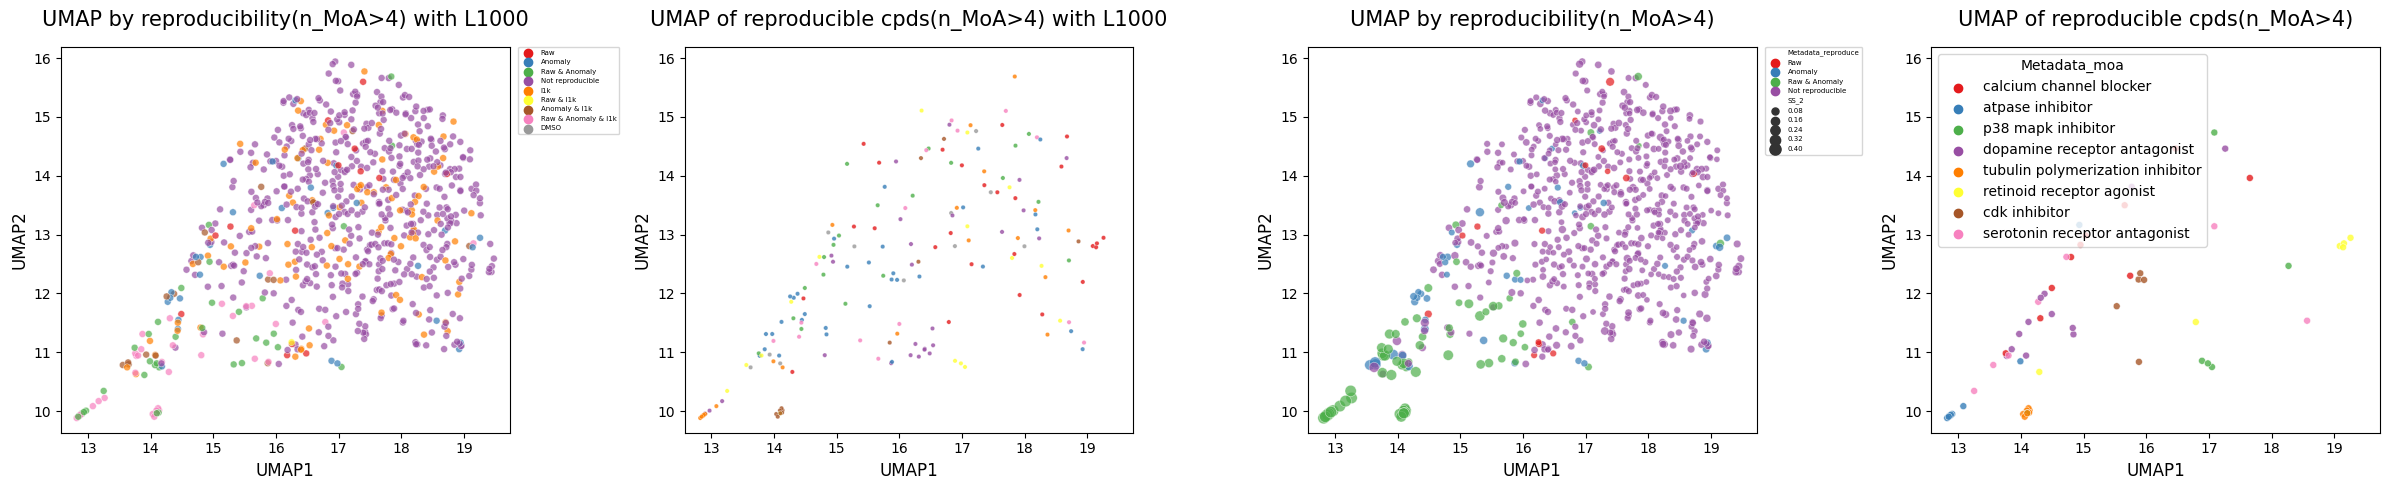

raw with (778, 457), n_Moa = 55
If we filter to MoAs which have more than 5  compounds in their category,  55  out of  55  MoAs remain.
There are  55 MoA categories, which out of them  0  have multi labels and is removed
If we filter to MoAs which have more than 5  compounds in their category,  23  out of  51  MoAs remain.
There are  23 MoA categories, which out of them  0  have multi labels and is removed
If we filter to MoAs which have more than 5  compounds in their category,  8  out of  43  MoAs remain.
There are  8 MoA categories, which out of them  0  have multi labels and is removed


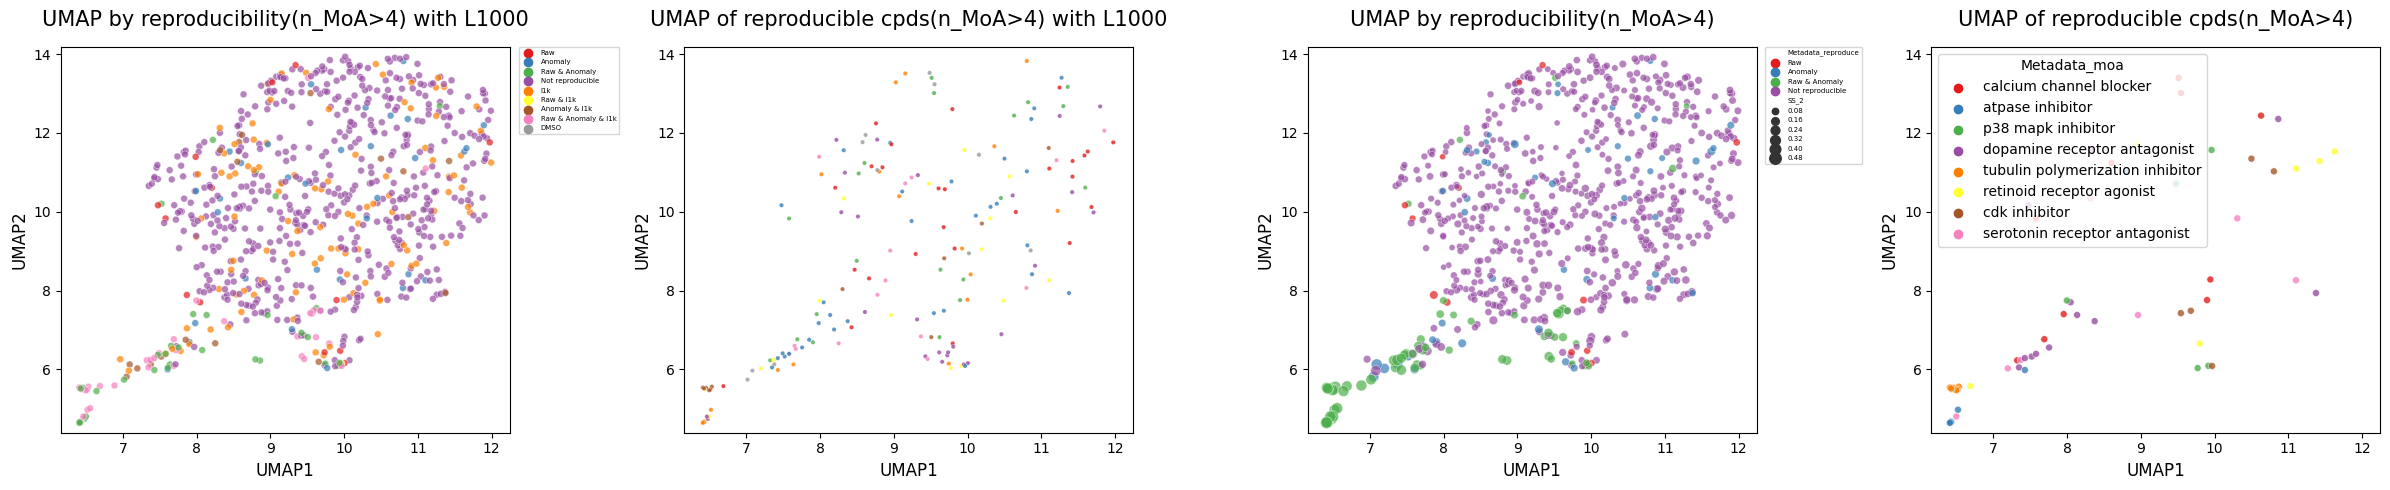

In [146]:
##### inspecting the treatment level profiles by MoA assosication #####

for m in methods.keys():
    # if model!='pure':

        # treatment level profiles 
        tlp = methods[m]['treatment_level'].copy()
        
        # filter out MoAs with less than 5 compounds

        print(f'{m} with {c.shape}, n_Moa = {len(tlp["Metadata_moa"].unique())}')
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 5))

        
        ######### with l1k #########
        hue_order = ['Raw', 'Anomaly', 'Raw & Anomaly','Not reproducible','l1k', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k','DMSO']
        # sns.scatterplot(data=tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,hue_order=hue_order,s=25)
        


        ## all cpds ##
        tlp_filtered = filter_by_moa(tlp, moa_col='Metadata_moa',nSamplesMOA=4)
        sns.scatterplot(data =tlp_filtered, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,hue_order=hue_order,s=25)

        ## only reproducible cpds ##
        tlp_only_reproduce = tlp[tlp[reproduce_label_with_l1k]!='Not reproducible']
        tlp_only_reproduce_filtered = filter_by_moa(tlp_only_reproduce, moa_col='Metadata_moa',nSamplesMOA=4)

        sns.scatterplot(data =tlp_only_reproduce_filtered, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, palette='Set1', ax=ax[1],legend=False, s=10)
        # hue_order = ['l1k', 'Raw', 'Anomaly', 'Raw & Anomaly', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k','Not reproducible']

        # c.loc[c[reproduce_label]!='Not reproducible','is_reproducible'] = 'True'
        # c.loc[c[reproduce_label]=='DMSO','is_reproducible'] = 'DMSO'
        # c.loc[c[reproduce_label]=='Not reproducible','is_reproducible'] = 'False'

        
        ######### without l1k #########

        ## all cpds ##
        hue_order = ['Raw', 'Anomaly', 'Raw & Anomaly','Not reproducible']

        # hue_order = ['l1k', 'Raw', 'Anomaly', 'Raw & Anomaly', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k']
        # hue_order = ['Raw', 'Anomaly', 'Raw & Anomaly']

        sns.scatterplot(data =tlp_filtered, x=f'{method}1',y=f'{method}2', hue=reproduce_label,alpha=0.7, size='SS_2', palette='Set1', ax=ax[2],legend=True,hue_order=hue_order,s=25)

        tlp_only_reproduce = tlp[tlp[reproduce_label]!='Not reproducible']
        tlp_only_reproduce_filtered = filter_by_moa(tlp_only_reproduce, moa_col='Metadata_moa',nSamplesMOA=4)

        sns.scatterplot(data =tlp_only_reproduce_filtered, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, palette='Set1', ax=ax[3],legend=True, s=25)

        # g = sns.scatterplot(data=c, x=f'{method}1', y=f'{method}2', hue="mock", s=10, palette=["red", "silver"],ax=ax[2])
        # sns.scatterplot(data=c, x=f'{method}1', y=f'{method}2', s=100, hue="Metadata_moa", palette="nipy_spectral",ax=ax[2],legend=False)

        ax[0].set_title(f'{method} by reproducibility(n_MoA>4) with L1000', fontsize=15, pad=15)
        # ax[1].set_title("PCA of plates by well", fontsize=15, pad=15)
        ax[1].set_title(f'{method} of reproducible cpds(n_MoA>4) with L1000', fontsize=15, pad=15)
        ax[2].set_title(f'{method} by reproducibility(n_MoA>4)', fontsize=15, pad=15)
        ax[3].set_title(f'{method} of reproducible cpds(n_MoA>4)', fontsize=15, pad=15)
        # ax[1].set_title("PCA of IRIS dataset", fontsize=15, pad=15)

        for i in range(len(ax)):
            ax[i].set_xlabel(f'{method}1', fontsize=12)
            ax[i].set_ylabel(f'{method}2', fontsize=12)
            if i% 2 == 0:
                ax[i].legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.,fontsize = 5)
            ax[i].set_xlim(methods[m]['umap_treatment_levels_lims'][0],methods[m]['umap_treatment_levels_lims'][1])
            ax[i].set_ylim(methods[m]['umap_treatment_levels_lims'][2],methods[m]['umap_treatment_levels_lims'][3])
            
        # ax[2].set_xlabel(f'{method}1', fontsize=12)
        # ax[2].set_ylabel(f'{method}2', fontsize=12)

        # plt.savefig(os.path.join(args.exp_dir,'PCA of '+ exp_name + '.png'), dpi=80)
        plt.tight_layout()
        plt.show()

### Only reproducible >5 cpds

In [147]:
# MoA_counts = methods[m]['treatment_level']['Metadata_moa'].value_counts()
lincs_moa_top=['mTOR inhibitor', 'glucocorticoid receptor agonist', 'HSP inhibitor',
       'proteasome inhibitor', 'MEK inhibitor', 'HDAC inhibitor',
       'tubulin polymerization inhibitor', 'PLK inhibitor', 'EGFR inhibitor',
       'retinoid receptor agonist', 'CDK inhibitor', 'topoisomerase inhibitor',
       'p38 MAPK inhibitor', 'AKT inhibitor', 'serotonin receptor antagonist',
       'gamma secretase inhibitor', 'HMGCR inhibitor', 'PI3K inhibitor',
       'rho associated kinase inhibitor', 'cyclooxygenase inhibitor',
       'protein synthesis inhibitor', 'histamine receptor antagonist',
       'sterol demethylase inhibitor', 'PKC inhibitor',
       'dopamine receptor antagonist', 'adrenergic receptor antagonist',
       'vitamin D receptor agonist', 'acetylcholine receptor antagonist',
       'progesterone receptor agonist', 'dopamine receptor agonist',
       'benzodiazepine receptor agonist', 'phosphodiesterase inhibitor',
       'calcium channel blocker', 'adrenergic receptor agonist','bacterial dna gyrase inhibitor']
lincs_moa_top = [m.lower() for m in lincs_moa_top]

cdrp_moa_top=['tubulin polymerization inhibitor', 'atpase inhibitor', 
       'retinoid receptor agonist',
       'glucocorticoid receptor agonist', 'cdk inhibitor',
       'adrenergic receptor agonist', 'dopamine receptor antagonist',
       'protein synthesis inhibitor', 'serotonin receptor antagonist',
       'calcium channel blocker', 'dopamine receptor agonist',
       'serotonin receptor agonist', 'adrenergic receptor antagonist',
       'p38 mapk inhibitor', 'opiod receptor agonist', 'bacterial cell wall sythesis inhibitor'] # last line is only to anomaly
cdrp_moa_top = [m.lower() for m in cdrp_moa_top]

# top_cdrp_lincs_overlap=list(set(lincs_moa_top) & set(cdrp_moa_top))
top_cdrp_lincs_overlap=['glucocorticoid receptor agonist',
 'tubulin polymerization inhibitor',
 'dopamine receptor antagonist',
 'protein synthesis inhibitor',
 'dopamine receptor agonist',
 'serotonin receptor antagonist',
 'adrenergic receptor antagonist',
 'adrenergic receptor agonist',
 'calcium channel blocker']

anomaly_enanbled_moas = tlp_only_reproduce[tlp_only_reproduce[reproduce_label_with_l1k].isin(['Anomaly','Anomaly & l1k','Raw & Anomaly','Raw & Anomaly & l1k'])]['Metadata_moa'].unique()
# anomaly_enanbled_moas_no_l1k = tlp_only_reproduce[tlp_only_reproduce[reproduce_label].isin(['Anomaly','Raw & Anomaly','Anomaly & l1k'])]['Metadata_moa'].unique()
anomaly_enanbled_moas_only = tlp_only_reproduce[tlp_only_reproduce[reproduce_label].isin(['Anomaly'])]['Metadata_moa'].unique()

# anomaly_enanbled_moas

if dataset == 'CDRP-bio':
       cdrp_moa_all_predictable = ['tubulin polymerization inhibitor', 'atpase inhibitor', 'glucocorticoid receptor agonist', 'cdk inhibitor', 'retinoid receptor agonist', 'adrenergic receptor agonist', 'dopamine receptor antagonist', 'p38 mapk inhibitor']
       cdrp_moa_top_predictable = ['tubulin polymerization inhibitor', 'atpase inhibitor', 'glucocorticoid receptor agonist', 'cdk inhibitor']
       anomaly_moas = ['retinoid receptor agonist', 'dopamine receptor antagonist', 'p38 mapk inhibitor', 'opioid receptor agonist', 'adrenergic receptor antagonist', 'calcium channel blocker', 'dopamine receptor agonist']

       # 'protein synthesis inhibitor', 'serotonin receptor antagonist', 'calcium channel blocker', 'dopamine receptor agonist', 'serotonin receptor agonist', 'adrenergic receptor antagonist']
else:
       cdrp_moa_top_predictable = ['glucocorticoid receptor agonist', 'egfr inhibitor', 'hdac inhibitor', 'tubulin polymerization inhibitor', 'topoisomerase inhibitor']
       anomaly_moas = ['phosphodiesterase inhibitor', 'bacterial dna gyrase inhibitor', 'histamine receptor antagonist', 'dopamine receptor antagonist', 'serotonin receptor antagonist']



# anomaly_moas
# if dataset == 'CDRP-bio':
# else:


In [148]:
top_or_all_predictable = 'top'

if top_or_all_predictable == 'top':
    cdrp_subgroup = cdrp_moa_top_predictable
else:
    cdrp_subgroup = cdrp_moa_all_predictable

methods[m]['treatment_level']['Metadata_moa'][methods[m]['treatment_level']['Metadata_moa'].isin(cdrp_subgroup)].value_counts()

Metadata_moa
glucocorticoid receptor agonist     24
atpase inhibitor                    11
cdk inhibitor                       10
tubulin polymerization inhibitor     7
Name: count, dtype: int64

anomaly_err with (778, 457), n_Moa = 55


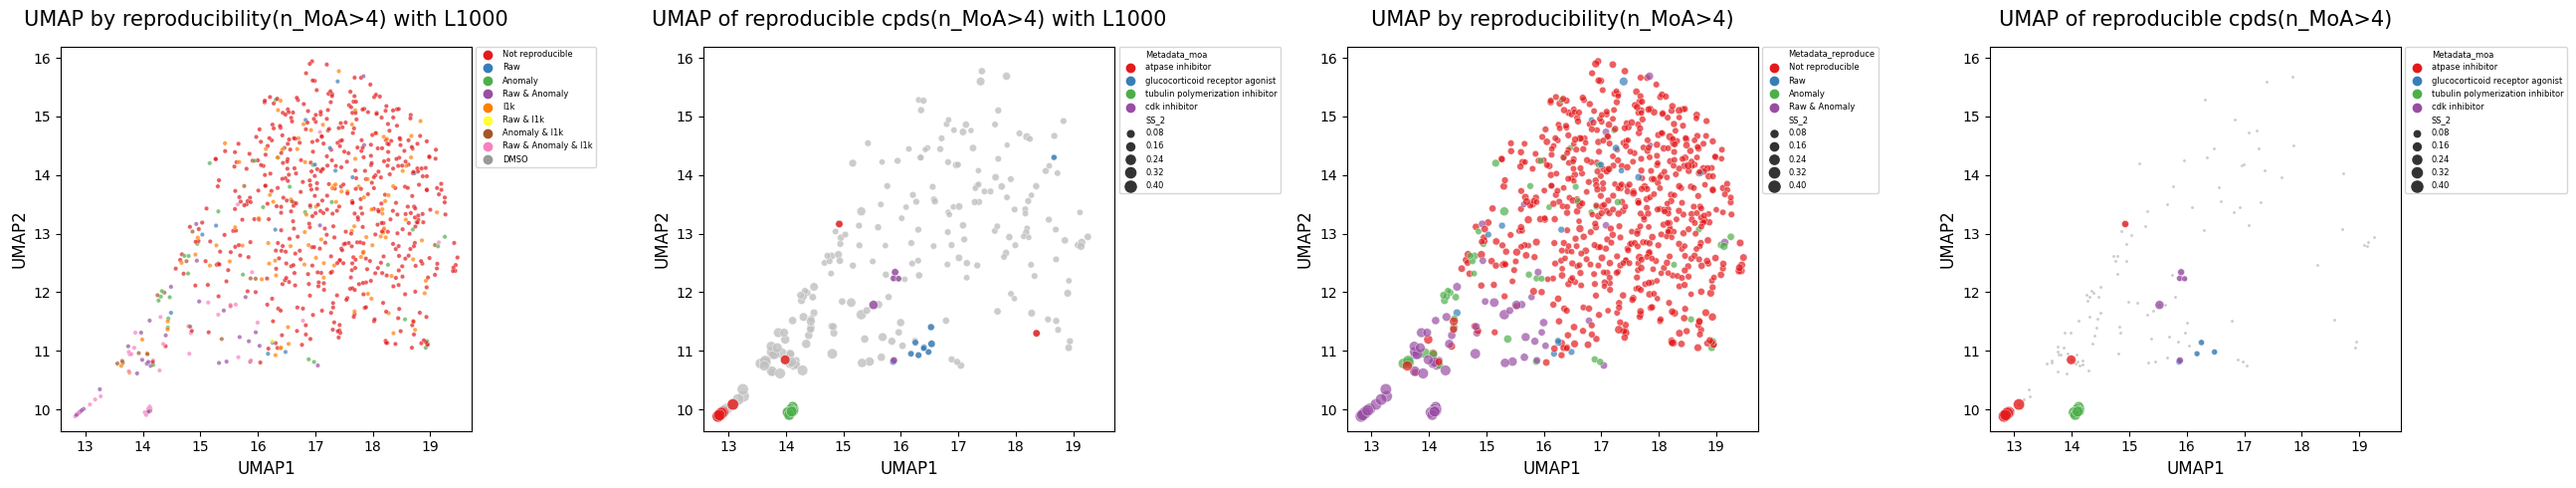

raw with (778, 457), n_Moa = 55


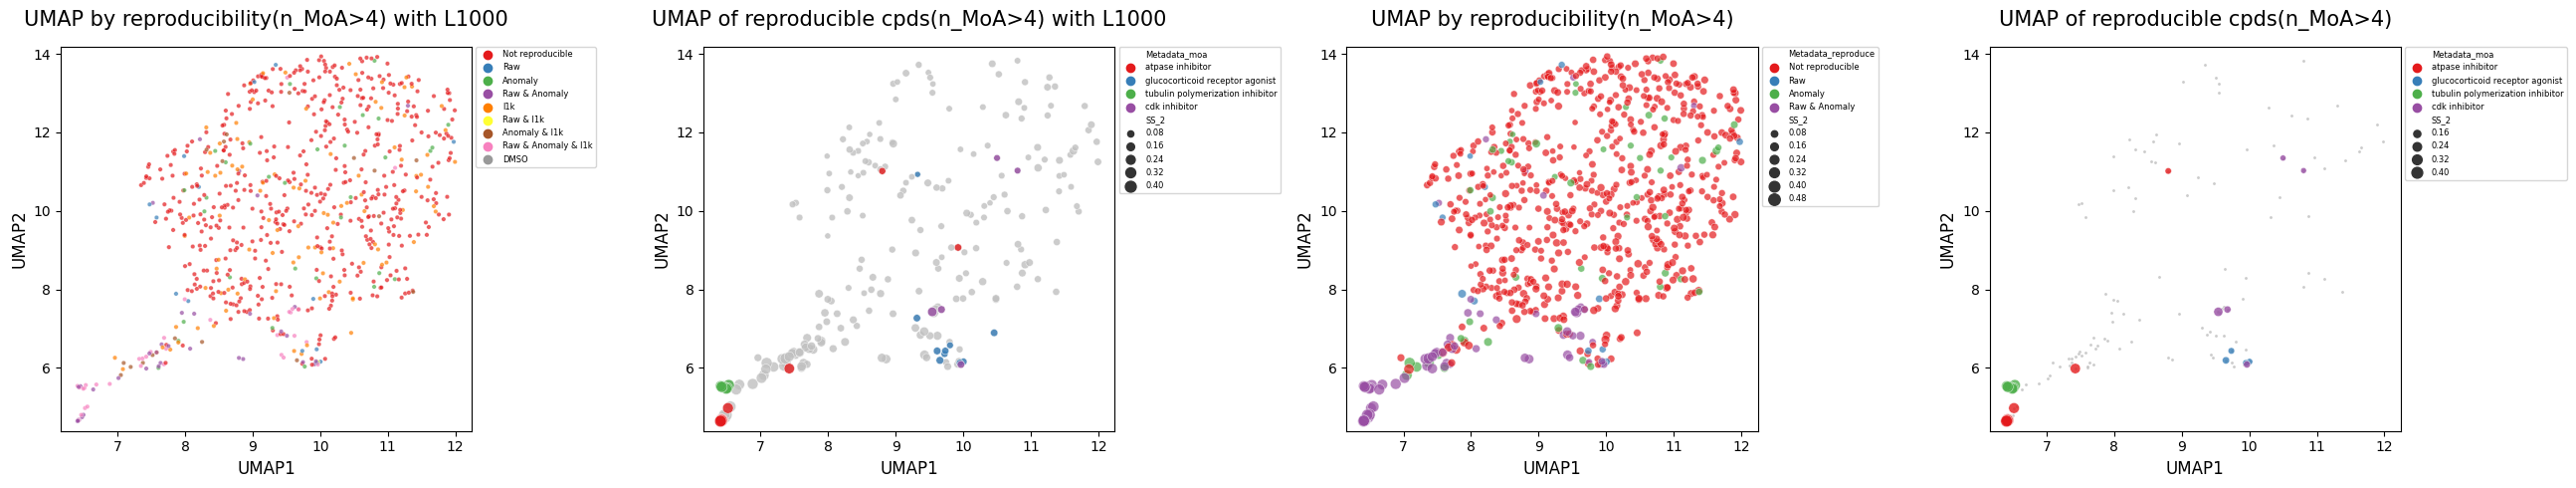

In [149]:
##### inspecting the treatment level profiles by MoA assosication #####
# options: Med_Corr, SS_2, MAS_2
size_column = 'SS_2'

for m in methods.keys():
    # if model!='pure':

        # treatment level profiles 
        tlp = methods[m]['treatment_level'].copy()
        top_predicatable = tlp[tlp['Metadata_moa'].isin(cdrp_subgroup)]
        # filter out MoAs with less than 5 compounds

        print(f'{m} with {c.shape}, n_Moa = {len(tlp["Metadata_moa"].unique())}')
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(26, 5))

        
        ######### with l1k #########
        hue_order = ['Not reproducible','Raw', 'Anomaly', 'Raw & Anomaly','l1k', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k','DMSO']
        # sns.scatterplot(data=tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,hue_order=hue_order,s=25)
        
        ## all cpds ##
        # tlp_filtered = tlp[tlp['Metadata_moa'].isin(tlp['Metadata_moa'].value_counts()[tlp['Metadata_moa'].value_counts()>4].index)]
        # sns.scatterplot(data =tlp_filtered, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,hue_order=hue_order,s=25)
        # sns.scatterplot(data =tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,hue_order=hue_order,s=25)
        sns.scatterplot(data =tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,s=10, hue_order=hue_order)
        # sns.scatterplot(data =tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, size=size_column, palette='Set1', ax=ax[0],legend=True,s=25, hue_order=hue_order)

        ## only reproducible cpds ##
        tlp_only_reproduce = tlp[tlp[reproduce_label_with_l1k]!='Not reproducible']
        top_predicatable_rep = top_predicatable[top_predicatable[reproduce_label_with_l1k]!='Not reproducible']
        # tlp_only_reproduce_filtered = tlp_only_reproduce[tlp_only_reproduce['Metadata_moa'].isin(tlp_only_reproduce['Metadata_moa'].value_counts()[tlp_only_reproduce['Metadata_moa'].value_counts()>4].index)]
        # sns.scatterplot(data =tlp_only_reproduce_filtered, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, palette='Set1', ax=ax[1],legend=True, s=25)
        sns.scatterplot(data =tlp_only_reproduce, x=f'{method}1',y=f'{method}2',alpha=0.8, size=size_column, color='silver', ax=ax[1],legend=False, s=1)
        sns.scatterplot(data =top_predicatable_rep, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, size=size_column, palette='Set1', ax=ax[1],legend=True, s=25)


        # hue_order = ['l1k', 'Raw', 'Anomaly', 'Raw & Anomaly', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k','Not reproducible']

        # c.loc[c[reproduce_label]!='Not reproducible','is_reproducible'] = 'True'
        # c.loc[c[reproduce_label]=='DMSO','is_reproducible'] = 'DMSO'
        # c.loc[c[reproduce_label]=='Not reproducible','is_reproducible'] = 'False'

        
        ######### without l1k #########

        ## all cpds ##
        hue_order = ['Not reproducible', 'Raw', 'Anomaly', 'Raw & Anomaly']

        # hue_order = ['l1k', 'Raw', 'Anomaly', 'Raw & Anomaly', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k']
        # hue_order = ['Raw', 'Anomaly', 'Raw & Anomaly']

        sns.scatterplot(data =tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label,alpha=0.7, size=size_column, palette='Set1', ax=ax[2],legend=True,hue_order=hue_order,s=25)

        tlp_only_reproduce = tlp[tlp[reproduce_label]!='Not reproducible']
        top_predicatable_rep = top_predicatable[top_predicatable[reproduce_label]!='Not reproducible']

        # tlp_only_reproduce_filtered = tlp_only_reproduce[tlp_only_reproduce['Metadata_moa'].isin(tlp_only_reproduce['Metadata_moa'].value_counts()[tlp_only_reproduce['Metadata_moa'].value_counts()>4].index)]

        # sns.scatterplot(data =tlp_only_reproduce_filtered, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, palette='Set1', ax=ax[3],legend=True, s=25)
        sns.scatterplot(data = tlp_only_reproduce, x=f'{method}1',y=f'{method}2',alpha=0.8, color='silver', ax=ax[3],legend=False, s=5)
        sns.scatterplot(data =top_predicatable_rep, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8,size=size_column, palette='Set1', ax=ax[3],legend=True, s=25)
        # sns.jointplot(data =tlp_only_reproduce_filtered, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, palette='Set1', ax=ax[3],legend=True, s=25)
        # g = sns.scatterplot(data=c, x=f'{method}1', y=f'{method}2', hue="mock", s=10, palette=["red", "silver"],ax=ax[2])
        # sns.scatterplot(data=c, x=f'{method}1', y=f'{method}2', s=100, hue="Metadata_moa", palette="nipy_spectral",ax=ax[2],legend=False)

        ax[0].set_title(f'{method} by reproducibility(n_MoA>4) with L1000', fontsize=15, pad=15)
        # ax[1].set_title("PCA of plates by well", fontsize=15, pad=15)
        ax[1].set_title(f'{method} of reproducible cpds(n_MoA>4) with L1000', fontsize=15, pad=15)
        ax[2].set_title(f'{method} by reproducibility(n_MoA>4)', fontsize=15, pad=15)
        ax[3].set_title(f'{method} of reproducible cpds(n_MoA>4)', fontsize=15, pad=15)
        # ax[1].set_title("PCA of IRIS dataset", fontsize=15, pad=15)

        for i in range(len(ax)):
            ax[i].set_xlabel(f'{method}1', fontsize=12)
            ax[i].set_ylabel(f'{method}2', fontsize=12)
            # if i% 2 == 0:
                # ax[i].legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.,fontsize = 8)
            ax[i].set_xlim(methods[m]['umap_treatment_levels_lims'][0],methods[m]['umap_treatment_levels_lims'][1])
            ax[i].set_ylim(methods[m]['umap_treatment_levels_lims'][2],methods[m]['umap_treatment_levels_lims'][3])
            
            ax[i].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,fontsize = 6)
        
        # ax[2].set_xlabel(f'{method}1', fontsize=12)
        # ax[2].set_ylabel(f'{method}2', fontsize=12)

        # plt.savefig(os.path.join(args.exp_dir,'PCA of '+ exp_name + '.png'), dpi=80)
        plt.tight_layout()
        plt.show()

In [150]:
# ##### inspecting the treatment level profiles by MoA assosication #####
# # # options: Med_Corr, SS_2, MAS_2
# # size_column = 'MAS_2'

# for m in methods.keys():
#     # if model!='pure':

#         # treatment level profiles 
#         tlp = methods[m]['treatment_level'].copy()
#         tlp_all = tlp.copy()
#         # tlp_all_rep = tlp[tlp[reproduce_label_with_l1k]!='Not reproducible']
#         # tlp_all_rep_filtered = tlp_all_rep[tlp_all_rep['Metadata_moa'].isin(tlp_all_rep['Metadata_moa'].value_counts()[tlp_all_rep['Metadata_moa'].value_counts()>4].index)]

#         tlp = tlp[tlp['Metadata_moa'].isin(cdrp_subgroup)]
#         # filter out MoAs with less than 5 compounds

#         print(f'{m} with {c.shape}, n_Moa = {len(tlp["Metadata_moa"].unique())}')
#         fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(26, 5))

        
#         ######### with l1k #########
#         hue_order = ['Not reproducible','Raw', 'Anomaly', 'Raw & Anomaly','l1k', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k','DMSO']
#         # sns.scatterplot(data=tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,hue_order=hue_order,s=25)
        
#         ## all cpds ##
#         sns.scatterplot(data =tlp_all, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,hue_order=hue_order,s=20)

#         ## only reproducible cpds ##
#         tlp_only_reproduce = tlp[tlp[reproduce_label_with_l1k]!='Not reproducible']
#         tlp_all_rep = tlp_all[tlp_all[reproduce_label_with_l1k]!='Not reproducible']
#         # tlp_only_reproduce_filtered = tlp_only_reproduce[tlp_only_reproduce['Metadata_moa'].isin(tlp_only_reproduce['Metadata_moa'].value_counts()[tlp_only_reproduce['Metadata_moa'].value_counts()>4].index)]
#         # sns.scatterplot(data =tlp_all_filtered, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, color='silver', ax=ax[1],legend=True,hue_order=hue_order,s=5)

#         sns.scatterplot(data = tlp_all_rep, x=f'{method}1',y=f'{method}2',alpha=0.8, color='silver', ax=ax[1],legend=False, s=5)
#         sns.scatterplot(data = tlp_only_reproduce, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, palette='Set1', ax=ax[1],legend=True, s=25)
#         # sns.scatterplot(data =tlp_only_reproduce, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, size=size_column, palette='Set1', ax=ax[1],legend=True, s=25)
#         # sns.jointplot(data =tlp_only_reproduce_filtered, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, palette='Set1', ax=ax[0],legend=True, s=25)

#         ######### without l1k #########

#         ## all cpds ##
#         hue_order = ['Not reproducible', 'Raw', 'Anomaly', 'Raw & Anomaly']
#         # sns.scatterplot(data =tlp_all, x=f'{method}1',y=f'{method}2',alpha=0.7, color='silver', ax=ax[2],legend=False,hue_order=hue_order,s=5)
#         sns.scatterplot(data =tlp_all, x=f'{method}1',y=f'{method}2', hue=reproduce_label,alpha=0.7, palette='Set1', ax=ax[2],legend=True,hue_order=hue_order,s=20)

#         tlp_only_reproduce = tlp[tlp[reproduce_label]!='Not reproducible']
#         tlp_all_rep = tlp_all[tlp_all[reproduce_label]!='Not reproducible']
#         sns.scatterplot(data = tlp_all_rep, x=f'{method}1',y=f'{method}2',alpha=0.8, color='silver', ax=ax[3],legend=False, s=5)
#         sns.scatterplot(data =tlp_only_reproduce, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, palette='Set1', ax=ax[3],legend=True, s=25)
#         # sns.jointplot(data =tlp_only_reproduce_filtered, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, palette='Set1', ax=ax[1],legend=True, s=25)
#         # g = sns.scatterplot(data=c, x=f'{method}1', y=f'{method}2', hue="mock", s=10, palette=["red", "silver"],ax=ax[2])
#         # sns.scatterplot(data=c, x=f'{method}1', y=f'{method}2', s=100, hue="Metadata_moa", palette="nipy_spectral",ax=ax[2],legend=False)

#         # ax[0].set_title(f'{method} by reproducibility(n_MoA>4) with L1000', fontsize=15, pad=15)
#         # ax[1].set_title("PCA of plates by well", fontsize=15, pad=15)
#         ax[0].set_title(f'{method} of reproducible cpds(n_MoA>4) with L1000', fontsize=15, pad=15)
#         # ax[2].set_title(f'{method} by reproducibility(n_MoA>4)', fontsize=15, pad=15)
#         ax[1].set_title(f'{method} of reproducible cpds(n_MoA>4)', fontsize=15, pad=15)
#         # ax[1].set_title("PCA of IRIS dataset", fontsize=15, pad=15)

#         for i in range(len(ax)):
#             ax[i].set_xlabel(f'{method}1', fontsize=12)
#             ax[i].set_ylabel(f'{method}2', fontsize=12)
#             # if i% 2 == 0:
#             ax[i].set_xlim(methods[m]['umap_treatment_levels_lims'][0],methods[m]['umap_treatment_levels_lims'][1])
#             ax[i].set_ylim(methods[m]['umap_treatment_levels_lims'][2],methods[m]['umap_treatment_levels_lims'][3])
            
#             ax[i].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,fontsize = 8)
        
#         # ax[2].set_xlabel(f'{method}1', fontsize=12)
#         # ax[2].set_ylabel(f'{method}2', fontsize=12)

#         # plt.savefig(os.path.join(args.exp_dir,'PCA of '+ exp_name + '.png'), dpi=80)
#         plt.tight_layout()
#         plt.show()

In [151]:
# tlp_filtered = tlp[tlp['Metadata_moa'].isin(tlp['Metadata_moa'].value_counts()[tlp['Metadata_moa'].value_counts()>4].index)]
# 
# tlp_filtered = tlp[tlp[reproduce_label_with_l1k]!='Not reproducible'][cpd_col].unique()
# tlp_filtered_excluding_anomaly = tlp[(tlp[reproduce_label_with_l1k]=='Raw & l1k') & (tlp[reproduce_label_with_l1k]=='Raw & Anomaly & l1k') & (tlp[reproduce_label_with_l1k]!='Raw & Anomaly')][cpd_col].unique()
# tlp_filtered_only_anomaly = tlp[(tlp[reproduce_label_with_l1k]=='Anomaly') | (tlp[reproduce_label_with_l1k]=='l1k & Anomaly')][cpd_col].unique()

# reproduce_label_with_l1k, reproduce_label
anomaly_enabled_moas_only = methods['anomaly_err']['treatment_level'][methods['anomaly_err']['treatment_level'][reproduce_label].isin(['Anomaly'])]
# for m in methods.keys():

    # tlp = methods[m]['treatment_level'].copy()
    # tlp_reproduce = tlp[tlp[reproduce_label]!='Not reproducible']
    # anomaly_enabled_moas_only = methods[m]['treatment_level'][methods[m]['treatment_level'][reproduce_label].isin(['Anomaly'])]

anomaly_enabled_moas_only.Metadata_moa.value_counts()[:7]

Metadata_moa
dopamine receptor antagonist     4
calcium channel blocker          4
serotonin receptor antagonist    4
histamine receptor antagonist    3
p38 mapk inhibitor               3
cannabinoid receptor agonist     3
retinoid receptor agonist        3
Name: count, dtype: int64

In [152]:
raw_reproducible = ['Raw', 'Raw & Anomaly']

original_moas = methods['raw']['treatment_level'][methods['raw']['treatment_level'][reproduce_label].isin(raw_reproducible)]
## count ratio of anomaly enabled MoAs per MoA
original_moas.Metadata_moa.value_counts()[:7]


Metadata_moa
atpase inhibitor                    9
dopamine receptor antagonist        8
tubulin polymerization inhibitor    7
calcium channel blocker             6
protein synthesis inhibitor         4
serotonin receptor antagonist       3
p38 mapk inhibitor                  3
Name: count, dtype: int64

In [153]:
a = anomaly_enabled_moas_only.Metadata_moa.value_counts()/methods['raw']['treatment_level'].Metadata_moa.value_counts()
a.sort_values(ascending=False)[:10]

Metadata_moa
retinoid receptor agonist       0.428571
gaba receptor modulator         0.333333
p38 mapk inhibitor              0.300000
opioid receptor agonist         0.300000
tachykinin antagonist           0.285714
cannabinoid receptor agonist    0.272727
calcium channel blocker         0.210526
cdk inhibitor                   0.200000
monoamine oxidase inhibitor     0.166667
hmgcr inhibitor                 0.166667
Name: count, dtype: float64

In [154]:
## calc ratio of anomaly enabled MoAs out of reproducible MoAs per MoA
# b = anomaly_enabled_moas_only.Metadata_moa.value_counts()/(methods['raw']['treatment_level'].Metadata_moa.value_counts()- original_moas.Metadata_moa.value_counts())
# b = anomaly_enabled_moas_only.Metadata_moa.value_counts()/original_moas.Metadata_moa.value_counts()
b = anomaly_enabled_moas_only.Metadata_moa.value_counts()/(anomaly_enabled_moas_only.Metadata_moa.value_counts() + original_moas.Metadata_moa.value_counts())
b.sort_values(ascending=False)[:10]


Metadata_moa
cannabinoid receptor agonist     0.750000
opioid receptor agonist          0.750000
tachykinin antagonist            0.666667
serotonin receptor antagonist    0.571429
egfr inhibitor                   0.500000
p38 mapk inhibitor               0.500000
phosphodiesterase inhibitor      0.500000
retinoid receptor agonist        0.500000
serotonin receptor agonist       0.500000
calcium channel blocker          0.400000
Name: count, dtype: float64

In [155]:

# all MoAs with anomaly ratio of 0.3 or more
# c= b[b>0.35]
# anomaly_moas = c.index.tolist()


In [156]:
anomaly_moas
if dataset == 'CDRP-bio':
    anomaly_moas = ['retinoid receptor agonist', 'dopamine receptor antagonist', 'p38 mapk inhibitor', 'opioid receptor agonist', 'adrenergic receptor antagonist', 'calcium channel blocker', 'dopamine receptor agonist']
else:
    anomaly_moas = ['phosphodiesterase inhibitor', 'bacterial dna gyrase inhibitor', 'histamine receptor antagonist', 'dopamine receptor antagonist', 'serotonin receptor antagonist', 'histamine receptor antagonist']

# anomaly_moas = ['retinoid receptor agonist', 'dopamine receptor antagonist', 'p38 mapk inhibitor', 'opioid receptor agonist', 'adrenergic receptor antagonist', 'calcium channel blocker', 'dopamine receptor agonist']

### investigate only predicatable MoAs

In [157]:
lincs_moa_top

['mtor inhibitor',
 'glucocorticoid receptor agonist',
 'hsp inhibitor',
 'proteasome inhibitor',
 'mek inhibitor',
 'hdac inhibitor',
 'tubulin polymerization inhibitor',
 'plk inhibitor',
 'egfr inhibitor',
 'retinoid receptor agonist',
 'cdk inhibitor',
 'topoisomerase inhibitor',
 'p38 mapk inhibitor',
 'akt inhibitor',
 'serotonin receptor antagonist',
 'gamma secretase inhibitor',
 'hmgcr inhibitor',
 'pi3k inhibitor',
 'rho associated kinase inhibitor',
 'cyclooxygenase inhibitor',
 'protein synthesis inhibitor',
 'histamine receptor antagonist',
 'sterol demethylase inhibitor',
 'pkc inhibitor',
 'dopamine receptor antagonist',
 'adrenergic receptor antagonist',
 'vitamin d receptor agonist',
 'acetylcholine receptor antagonist',
 'progesterone receptor agonist',
 'dopamine receptor agonist',
 'benzodiazepine receptor agonist',
 'phosphodiesterase inhibitor',
 'calcium channel blocker',
 'adrenergic receptor agonist',
 'bacterial dna gyrase inhibitor']

In [158]:
do_only_predicatable = True

if dataset == 'CDRP-bio':
    predicatable_moas = cdrp_moa_top
else:
    predicatable_moas = lincs_moa_top

In [159]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
import umap


# pcas={}
# tsnes={}
# umaps={}
field_name = 'treatment_level_top'

for m in methods.keys():
    print(m)
    # if model!='pure':
    if m == 'raw_unchnaged':
        methods[m]['features'] = methods['raw']['features']
    
    if do_only_predicatable:
        methods[m][field_name] = methods[m]['treatment_level'][methods[m]['treatment_level']['Metadata_moa'].isin(predicatable_moas)].reset_index(drop=True)
        # methods[m][field_name] = methods[m][field_name].drop(columns=['UMAP1','UMAP2'])
    else:
        reproducible_moas = methods[m]['treatment_level'][methods[m]['treatment_level'][reproduce_label]!='Not reproducible']['Metadata_moa'].value_counts()>4
        reproducible_moas = reproducible_moas[reproducible_moas].index.tolist()
        methods[m][field_name] = methods[m]['treatment_level'][methods[m]['treatment_level']['Metadata_moa'].isin(reproducible_moas)]
    methods[m][field_name] = methods[m][field_name].drop(columns=['UMAP1','UMAP2'])
    x = methods[m][field_name][methods[m]['features']]

    X_scaled = x.copy()
    # print('Running PCA...')

    print('Running UMAP...')

    reducer = umap.UMAP(n_neighbors=15, n_components=2)
    # methods[m]['zscores_umap'] = {}
    X_reduced = reducer.fit_transform(X_scaled)
    print(X_reduced.shape)
    print(methods[m][field_name].shape)
    methods[m][field_name] = pd.concat([methods[m][field_name],pd.DataFrame(X_reduced,columns=['UMAP1','UMAP2'])],axis=1)
    # umap_zscores= pd.concat([methods[m]['zscores'],pd.DataFrame(X_reduced,columns=['UMAP1','UMAP2'])],axis=1)

    pad = 0.25
    methods[m][f'umap_{field_name}_lims'] = [methods[m][field_name]['UMAP1'].min()-pad,methods[m][field_name]['UMAP1'].max()+pad,methods[m][field_name]['UMAP2'].min()-pad,methods[m][field_name]['UMAP2'].max()+pad]
    print(methods[m][field_name].shape)

anomaly_err
Running UMAP...
(317, 2)
(317, 454)
(317, 456)
raw
Running UMAP...
(317, 2)
(317, 454)
(317, 456)


In [160]:
cdrp_subgroup
# methods[m][field_name]['Metadata_moa'][methods[m][field_name]['Metadata_moa'].isin(cdrp_subgroup)].value_counts()

['tubulin polymerization inhibitor',
 'atpase inhibitor',
 'glucocorticoid receptor agonist',
 'cdk inhibitor']

anomaly_err with (778, 457), n_Moa = 14


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


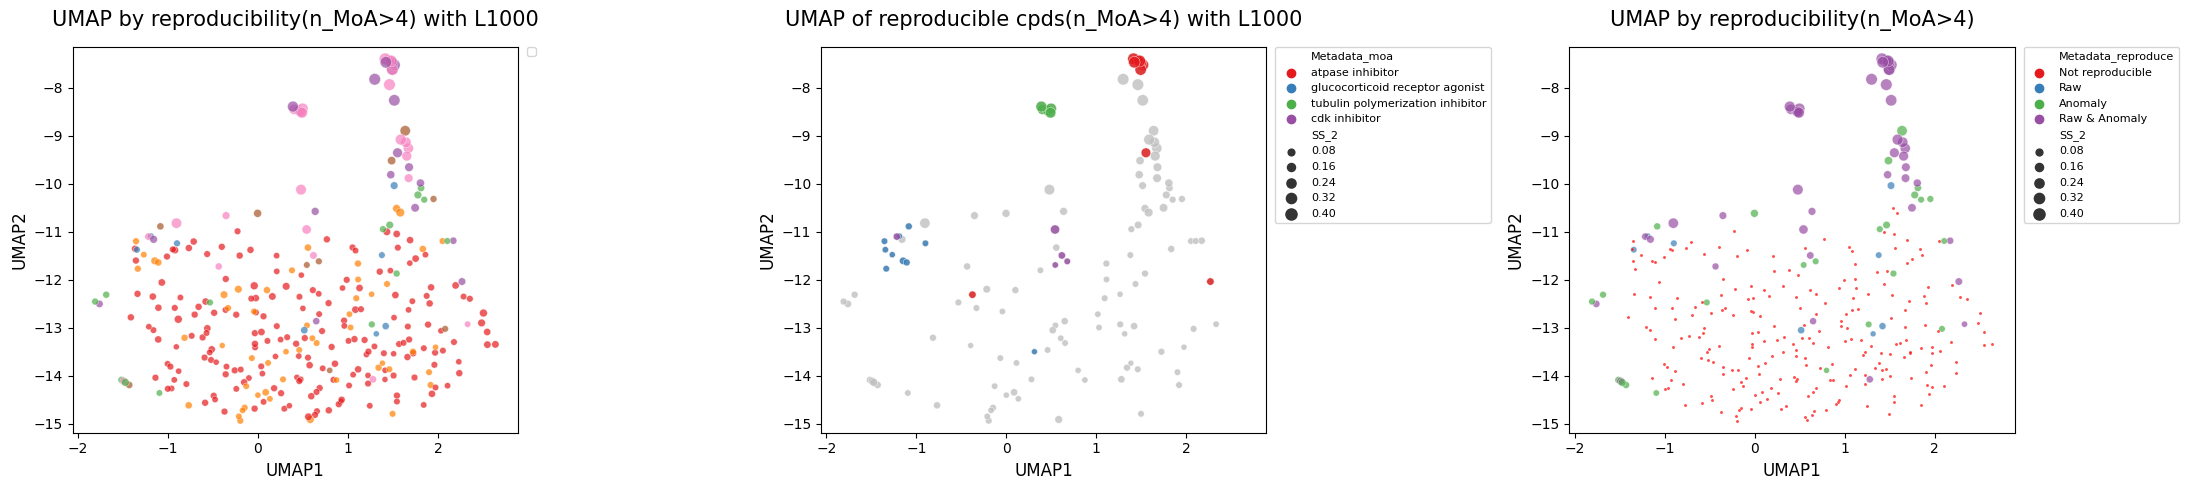

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


raw with (778, 457), n_Moa = 14


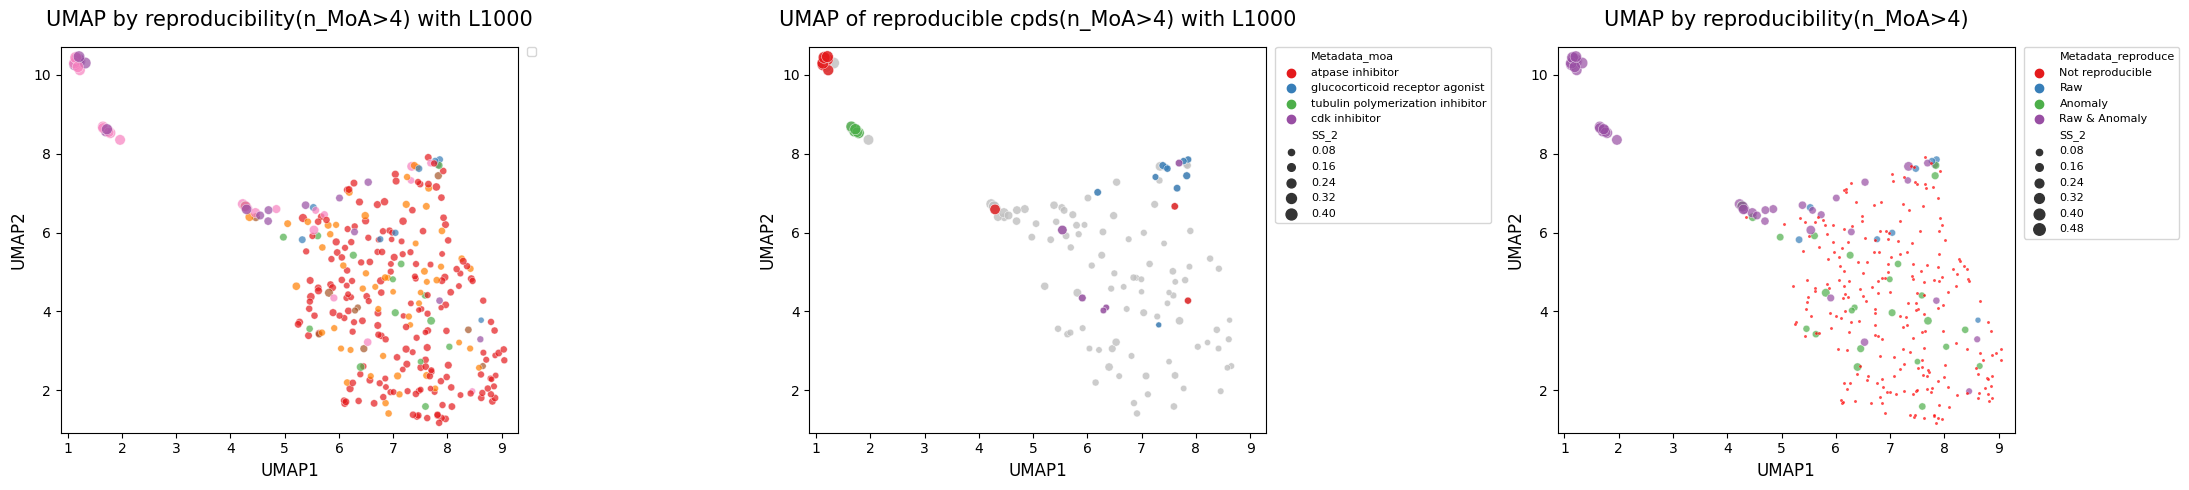

In [172]:
##### inspecting the treatment level profiles by MoA assosication #####
# options: Med_Corr, SS_2, MAS_2
size_column = 'SS_2'
method='UMAP'

for m in methods.keys():
    # if model!='pure':

        # treatment level profiles 
        tlp = methods[m][field_name].copy()
        top_predicatable = tlp[tlp['Metadata_moa'].isin(cdrp_subgroup)]
        # filter out MoAs with less than 5 compounds

        print(f'{m} with {c.shape}, n_Moa = {len(tlp["Metadata_moa"].unique())}')
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))

        
        ######### with l1k #########
        hue_order = ['Not reproducible','Raw', 'Anomaly', 'Raw & Anomaly','l1k', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k','DMSO']
        # sns.scatterplot(data=tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,hue_order=hue_order,s=25)
        
        ## all cpds ##
        # sns.scatterplot(data =tlp_filtered, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,hue_order=hue_order,s=25)
        # sns.scatterplot(data =tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,hue_order=hue_order,s=25)
        sns.scatterplot(data =tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, size=size_column, palette='Set1', ax=ax[0],legend=False,s=25, hue_order=hue_order)
        # sns.scatterplot(data =tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, size=size_column, palette='Set1', ax=ax[0],legend=True,s=25, hue_order=hue_order)

        ## only reproducible cpds ##
        tlp_only_reproduce = tlp[tlp[reproduce_label_with_l1k]!='Not reproducible']
        top_predicatable_rep = top_predicatable[top_predicatable[reproduce_label_with_l1k]!='Not reproducible']
        # tlp_only_reproduce_filtered = tlp_only_reproduce[tlp_only_reproduce['Metadata_moa'].isin(tlp_only_reproduce['Metadata_moa'].value_counts()[tlp_only_reproduce['Metadata_moa'].value_counts()>4].index)]
        # sns.scatterplot(data =tlp_only_reproduce_filtered, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, palette='Set1', ax=ax[1],legend=True, s=25)
        sns.scatterplot(data =tlp_only_reproduce, x=f'{method}1',y=f'{method}2',alpha=0.8, size=size_column, color='silver', ax=ax[1],legend=False, s=1)
        sns.scatterplot(data =top_predicatable_rep, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, size=size_column, palette='Set1', ax=ax[1],legend=True, s=25)
        
        ######### without l1k #########

        ## all cpds ##
        hue_order = ['Not reproducible', 'Raw', 'Anomaly', 'Raw & Anomaly']

        # hue_order = ['l1k', 'Raw', 'Anomaly', 'Raw & Anomaly', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k']
        # hue_order = ['Raw', 'Anomaly', 'Raw & Anomaly']
        tlp_only_reproduce = tlp[tlp[reproduce_label]!='Not reproducible']
        tlp_not_reproduce = tlp[tlp[reproduce_label]=='Not reproducible']

        sns.scatterplot(data =tlp_only_reproduce, x=f'{method}1',y=f'{method}2', hue=reproduce_label,alpha=0.7, size=size_column, palette='Set1', ax=ax[2],legend=True,hue_order=hue_order,s=25)
        sns.scatterplot(data =tlp_not_reproduce, x=f'{method}1',y=f'{method}2',alpha=0.7, color='red', ax=ax[2],legend=False,s=5)

        # tlp_only_reproduce = tlp[tlp[reproduce_label]!='Not reproducible']
        # tlp_only_reproduce_filtered = tlp_only_reproduce[tlp_only_reproduce['Metadata_moa'].isin(tlp_only_reproduce['Metadata_moa'].value_counts()[tlp_only_reproduce['Metadata_moa'].value_counts()>4].index)]
        # sns.scatterplot(data = tlp_all_rep, x=f'{method}1',y=f'{method}2',alpha=0.8, color='silver', ax=ax[3],legend=False, s=5)
        # sns.scatterplot(data =tlp_only_reproduce, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, palette='Set1', ax=ax[3],legend=False, s=25)

        ax[0].set_title(f'{method} by reproducibility(n_MoA>4) with L1000', fontsize=15, pad=15)
        # ax[1].set_title("PCA of plates by well", fontsize=15, pad=15)
        ax[1].set_title(f'{method} of reproducible cpds(n_MoA>4) with L1000', fontsize=15, pad=15)
        ax[2].set_title(f'{method} by reproducibility(n_MoA>4)', fontsize=15, pad=15)
        # ax[3].set_title(f'{method} of reproducible cpds(n_MoA>4)', fontsize=15, pad=15)
        # ax[1].set_title("PCA of IRIS dataset", fontsize=15, pad=15)

        for i in range(len(ax)):
            ax[i].set_xlabel(f'{method}1', fontsize=12)
            ax[i].set_ylabel(f'{method}2', fontsize=12)
            # if i% 2 == 0:
            ax[i].legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.,fontsize = 8)
            ax[i].set_xlim(methods[m][f'umap_{field_name}_lims'][0],methods[m][f'umap_{field_name}_lims'][1])
            ax[i].set_ylim(methods[m][f'umap_{field_name}_lims'][2],methods[m][f'umap_{field_name}_lims'][3])
            
            # ax[i].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,fontsize = 8)
        
        # ax[2].set_xlabel(f'{method}1', fontsize=12)
        # ax[2].set_ylabel(f'{method}2', fontsize=12)

        # plt.savefig(os.path.join(args.exp_dir,'PCA of '+ exp_name + '.png'), dpi=80)
        plt.tight_layout()
        plt.show()

In [162]:
top_predicatable['Metadata_moa'].value_counts()

Metadata_moa
glucocorticoid receptor agonist     24
atpase inhibitor                    11
cdk inhibitor                       10
tubulin polymerization inhibitor     7
Name: count, dtype: int64

anomaly_err with (778, 457), n_Moa = 14


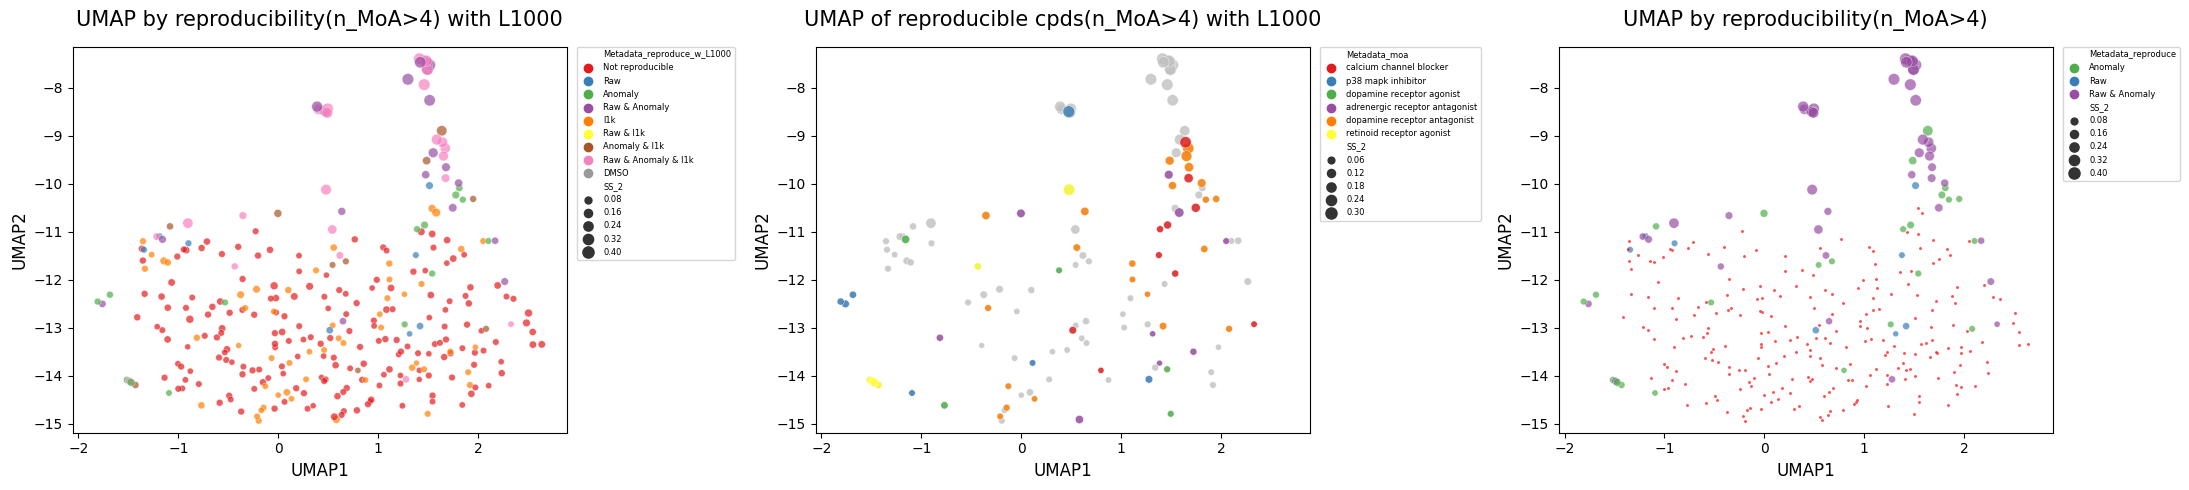

raw with (778, 457), n_Moa = 14


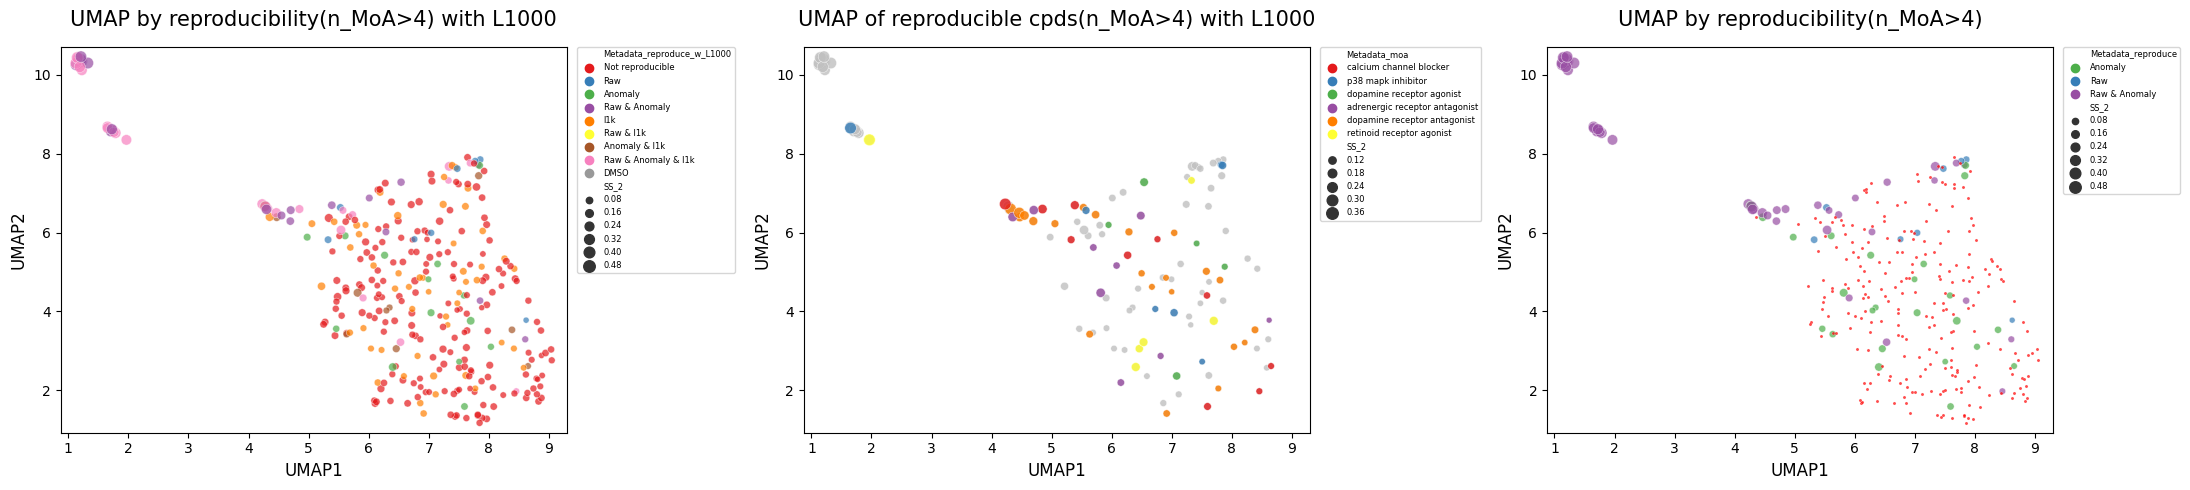

In [171]:
##### inspecting the treatment level profiles by MoA assosication #####
# options: Med_Corr, SS_2, MAS_2
size_column = 'SS_2'
method='UMAP'

for m in methods.keys():
    # if model!='pure':

        # treatment level profiles 
        tlp = methods[m][field_name].copy()
        top_predicatable = tlp[tlp['Metadata_moa'].isin(anomaly_moas)]
        # filter out MoAs with less than 5 compounds

        print(f'{m} with {c.shape}, n_Moa = {len(tlp["Metadata_moa"].unique())}')
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))

        
        ######### with l1k #########
        hue_order = ['Not reproducible','Raw', 'Anomaly', 'Raw & Anomaly','l1k', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k','DMSO']
        # sns.scatterplot(data=tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,hue_order=hue_order,s=25)
        
        ## all cpds ##
        # tlp_filtered = tlp[tlp['Metadata_moa'].isin(tlp['Metadata_moa'].value_counts()[tlp['Metadata_moa'].value_counts()>4].index)]
        # sns.scatterplot(data =tlp_filtered, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,hue_order=hue_order,s=25)
        # sns.scatterplot(data =tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, palette='Set1', ax=ax[0],legend=True,hue_order=hue_order,s=25)
        sns.scatterplot(data =tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, size=size_column, palette='Set1', ax=ax[0],legend=True,s=25, hue_order=hue_order)
        # sns.scatterplot(data =tlp, x=f'{method}1',y=f'{method}2', hue=reproduce_label_with_l1k,alpha=0.7, size=size_column, palette='Set1', ax=ax[0],legend=True,s=25, hue_order=hue_order)

        ## only reproducible cpds ##
        tlp_only_reproduce = tlp[tlp[reproduce_label_with_l1k]!='Not reproducible']
        top_predicatable_rep = top_predicatable[top_predicatable[reproduce_label_with_l1k]!='Not reproducible']
        # tlp_only_reproduce_filtered = tlp_only_reproduce[tlp_only_reproduce['Metadata_moa'].isin(tlp_only_reproduce['Metadata_moa'].value_counts()[tlp_only_reproduce['Metadata_moa'].value_counts()>4].index)]
        # sns.scatterplot(data =tlp_only_reproduce_filtered, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, palette='Set1', ax=ax[1],legend=True, s=25)
        sns.scatterplot(data =tlp_only_reproduce, x=f'{method}1',y=f'{method}2',alpha=0.8, size=size_column, color='silver', ax=ax[1],legend=False, s=1)
        sns.scatterplot(data =top_predicatable_rep, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, size=size_column, palette='Set1', ax=ax[1],legend=True, s=25)


        # hue_order = ['l1k', 'Raw', 'Anomaly', 'Raw & Anomaly', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k','Not reproducible']

        # c.loc[c[reproduce_label]!='Not reproducible','is_reproducible'] = 'True'
        # c.loc[c[reproduce_label]=='DMSO','is_reproducible'] = 'DMSO'
        # c.loc[c[reproduce_label]=='Not reproducible','is_reproducible'] = 'False'

        
        ######### without l1k #########

        ## all cpds ##
        hue_order = ['Anomaly', 'Raw', 'Anomaly', 'Raw & Anomaly'] #'Not reproducible'

        # hue_order = ['l1k', 'Raw', 'Anomaly', 'Raw & Anomaly', 'Raw & l1k', 'Anomaly & l1k', 'Raw & Anomaly & l1k']
        # hue_order = ['Raw', 'Anomaly', 'Raw & Anomaly']
        tlp_only_reproduce = tlp[tlp[reproduce_label]!='Not reproducible']
        tlp_not_reproduce = tlp[tlp[reproduce_label]=='Not reproducible']

        sns.scatterplot(data =tlp_only_reproduce, x=f'{method}1',y=f'{method}2', hue=reproduce_label,alpha=0.7, size=size_column, palette='Set1', ax=ax[2],legend=True,hue_order=hue_order,s=25)
        sns.scatterplot(data =tlp_not_reproduce, x=f'{method}1',y=f'{method}2',alpha=0.7, color='red', ax=ax[2],legend=False,s=5)

        # tlp_only_reproduce = tlp[tlp[reproduce_label]!='Not reproducible']
        top_predicatable_rep = top_predicatable[top_predicatable[reproduce_label]!='Not reproducible']

        # sns.scatterplot(data =tlp_only_reproduce_filtered, x=f'{method}1',y=f'{method}2', hue='Metadata_moa',alpha=0.8, palette='Set1', ax=ax[3],legend=True, s=25)
        # sns.scatterplot(data = tlp_only_reproduce, x=f'{method}1',y=f'{method}2',alpha=0.8, size=size_column, color='silver', ax=ax[3],legend=False, s=5)
        # sns.scatterplot(data =top_predicatable_rep, x=f'{method}1',y=f'{method}2', size=size_column, hue='Metadata_moa',alpha=0.8, palette='Set1', ax=ax[3],legend=True, s=25)


        ax[0].set_title(f'{method} by reproducibility(n_MoA>4) with L1000', fontsize=15, pad=15)
        # ax[1].set_title("PCA of plates by well", fontsize=15, pad=15)
        ax[1].set_title(f'{method} of reproducible cpds(n_MoA>4) with L1000', fontsize=15, pad=15)
        ax[2].set_title(f'{method} by reproducibility(n_MoA>4)', fontsize=15, pad=15)
        # ax[3].set_title(f'{method} of reproducible cpds(n_MoA>4)', fontsize=15, pad=15)
        # ax[1].set_title("PCA of IRIS dataset", fontsize=15, pad=15)

        for i in range(len(ax)):
            ax[i].set_xlabel(f'{method}1', fontsize=12)
            ax[i].set_ylabel(f'{method}2', fontsize=12)
            # if i% 2 == 0:
            ax[i].legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.,fontsize = 6)
            ax[i].set_xlim(methods[m][f'umap_{field_name}_lims'][0],methods[m][f'umap_{field_name}_lims'][1])
            ax[i].set_ylim(methods[m][f'umap_{field_name}_lims'][2],methods[m][f'umap_{field_name}_lims'][3])
            
            # ax[i].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,fontsize = 8)
        
        # ax[2].set_xlabel(f'{method}1', fontsize=12)
        # ax[2].set_ylabel(f'{method}2', fontsize=12)

        # plt.savefig(os.path.join(args.exp_dir,'PCA of '+ exp_name + '.png'), dpi=80)
        plt.tight_layout()
        plt.show()